# <p style="text-align: center;"> **Bayesian Analysis of ARPAV time series on temperatures and precipitations**</p>
## <p style="text-align: center;">  Advanced Statistics for Physics Analysis Project - 17 July 2024</p>

*ARPAV* (Agenzia Regionale per la iPrevenzione e Protezione Ambientale del Veneto) is an agency widespread over the territory that collects and analyzes environmental data. Some of the measurement points are quite old and a very long time serie (for example in Cavanis, Venice, daily measurements are available since 1900).
The aim of the project is to analyze the data available in three stations from 1993 to 2021, where the environment is quite different, and study the evolution over time. The stations are located in:<br>
- Auronzo di Cadore ( Lat: *46°33'33"* N, Long: *12°25'28"* E, Alt over sea level: 887 m);<br>
- Castelfranco Veneto ( Lat: *45°40'00"* N, Long: *11°55'00"* E, Alt over sea level: 46 m);<br>
- Porto Tolle ( Lat: *44°56'58"* N, Long: *12°19'28"* E, Alt over sea level: -22 m);<br>
- Roverchiara ( Lat: *45°16'10"* N, Long: *11°14'41"* E, Alt over sea level: 20 m).<br>

We start by importing the necessary R packages.

In [ ]:
library(dplyr)
library(readr)
library(lubridate)
library(purrr)
library(tools)
library(ggplot2)
library(gridExtra)
library(stats)
library(R2jags)
library(coda)
library(forecast)

## **Storing The Dataset**

Next we define some functions to read and store the dataset in dedicated R data frames using the tidyverse tools.

In [201]:
create_dataset <- function(Monthly=FALSE,Yearly=FALSE) {
      
      data_folder <- "./datiarpav"
    
      # Ottenere la lista di tutti i file con estensione .csv
      file_csv <- list.files(path = data_folder, pattern = "*.csv", full.names = TRUE)    
      # Creare un dataframe combinando i dati dai file CSV
      df <- file_csv |>
            map_df(~ read_csv(.x, show_col_types = FALSE) |>
            na.omit() |>
            mutate(file = file_path_sans_ext(basename(.x)),
                   month = ym(format(date, "%Y-%m")),
                   year_only = year(date))) |>
            filter(date >= as.Date('1993-01-01') & date <= as.Date('2021-12-31')) |>
            relocate( month, year_only, file, .after = date) |>
            arrange(date)     
            
      # Aggiungere colonne year e month_only
      df <- df |>
            mutate(month_only = as.double(format(month, "%m"))) |>
            relocate(month_only, .after = year_only)

      # dataset con summary mensili
      if(Monthly){
            df <- df |> group_by(month) |> summarise(MIN_mean = mean(TMIN), MED_mean = mean(TMED), MAX_mean = mean(TMAX)) |> 
                  mutate(year_only = as.double(format(month, "%Y")), month_only = as.double(format(month, "%m")))|>
            relocate(month_only, year_only, .after = month)
      }
      # dataset con summary annuali 
      if(Yearly){
            df <- df |> group_by(year_only) |> summarise(MIN_mean = mean(TMIN), MED_mean = mean(TMED), MAX_mean = mean(TMAX)) |> mutate(x_fit = year_only - min(year_only))
      }

    return(df)
}

# funzione per analizzare singoli mesi 
month_analisis <- function(df, n){
      m_df <- df[df$month_only == n,]
      return(m_df)
}



In [202]:
daily_dataset <- create_dataset()
monthly_dataset <- create_dataset(Monthly =   TRUE) 
yearly_dataset <- create_dataset(Yearly = TRUE)

## **Preliminary Analysis**


We begin our analysis with a preliminary study of the minimum, average and maximum temperatures from month to month (averaging them out on all the available stations)

In [104]:
# monthly heatmap
create_heatmap <- function(df, str, index){
    time_interval = 10              # past months to consider for the difference
    years <- unique(df$year_only)   
    num_years <- length(years)
    heatmap_data <- data.frame()
    
    for (n in 1:12) {
        month_evolution <- month_analisis(df, n)      # estraiamo una summary dei mesi 
        if(names(str)[index] == 'Minimum'){
            month_temp <- month_evolution$MIN_mean     # estraiamo solo la temperatura     
        }  
        else if(names(str)[index] == 'Maximum'){
            month_temp <- month_evolution$MAX_mean     
        }    
        else(names(str)[index] == 'Average')
            month_temp <- month_evolution$MED_mean 
        
        diff <- c()
        
        for (t in (time_interval+1):length(month_temp)) {         # computiamo la differenza tra temperatura di un anno e la media dei 10 anni precedenti
            t_mean <- mean(month_temp[(t-time_interval):(t-1)])
            diff_i <- month_temp[t] - t_mean
            diff <- c(diff, diff_i)
        }
        
        temp_df <- data.frame(                        # costruiamo la heatmap 
            Month = rep(n, length(diff)),
            Year = month_evolution$year_only[(time_interval+1):length(month_temp)],
            Difference = diff
        )
        heatmap_data <- rbind(heatmap_data, temp_df)
    }
    
    # plot 
    heatmap_plot <- ggplot(heatmap_data, aes(x = Year, y = Month, fill = Difference)) +
        geom_tile() +
        scale_fill_gradient2(low = "navy", mid = "white", high = "orange", midpoint = 0) +
        labs(title = paste(names(str)[index], "Monthly T. difference w.r.t. 10 years before"),
             x = "Year",
             y = "Month",
             fill = "Difference") +
        theme_bw()+
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))


    return(list(heatmap_plot, heatmap_data, mean(heatmap_data$Difference),var(heatmap_data$Difference)))
}

#Temperature difference distribution
norm_plot <- function(mean,var,type,index){
  x_axis = seq(-5,5,0.001)
  dist = dnorm(x=x_axis,sd = sqrt(var), mean = mean)
  df <- data.frame(x = x_axis, y = dist)
  p <- ggplot(df, aes(x = x, y = y)) + 
  geom_line(color = type[[index]], linewidth = 2) + 
  geom_vline(aes(xintercept = mean), linetype = 2) +
  theme_bw()+
  labs(title = paste(names(type)[index],'Temperature Difference Distribution '),
       x = 'Temperature (°C)',
       y = 'Density') + 
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))
 return (p)
}

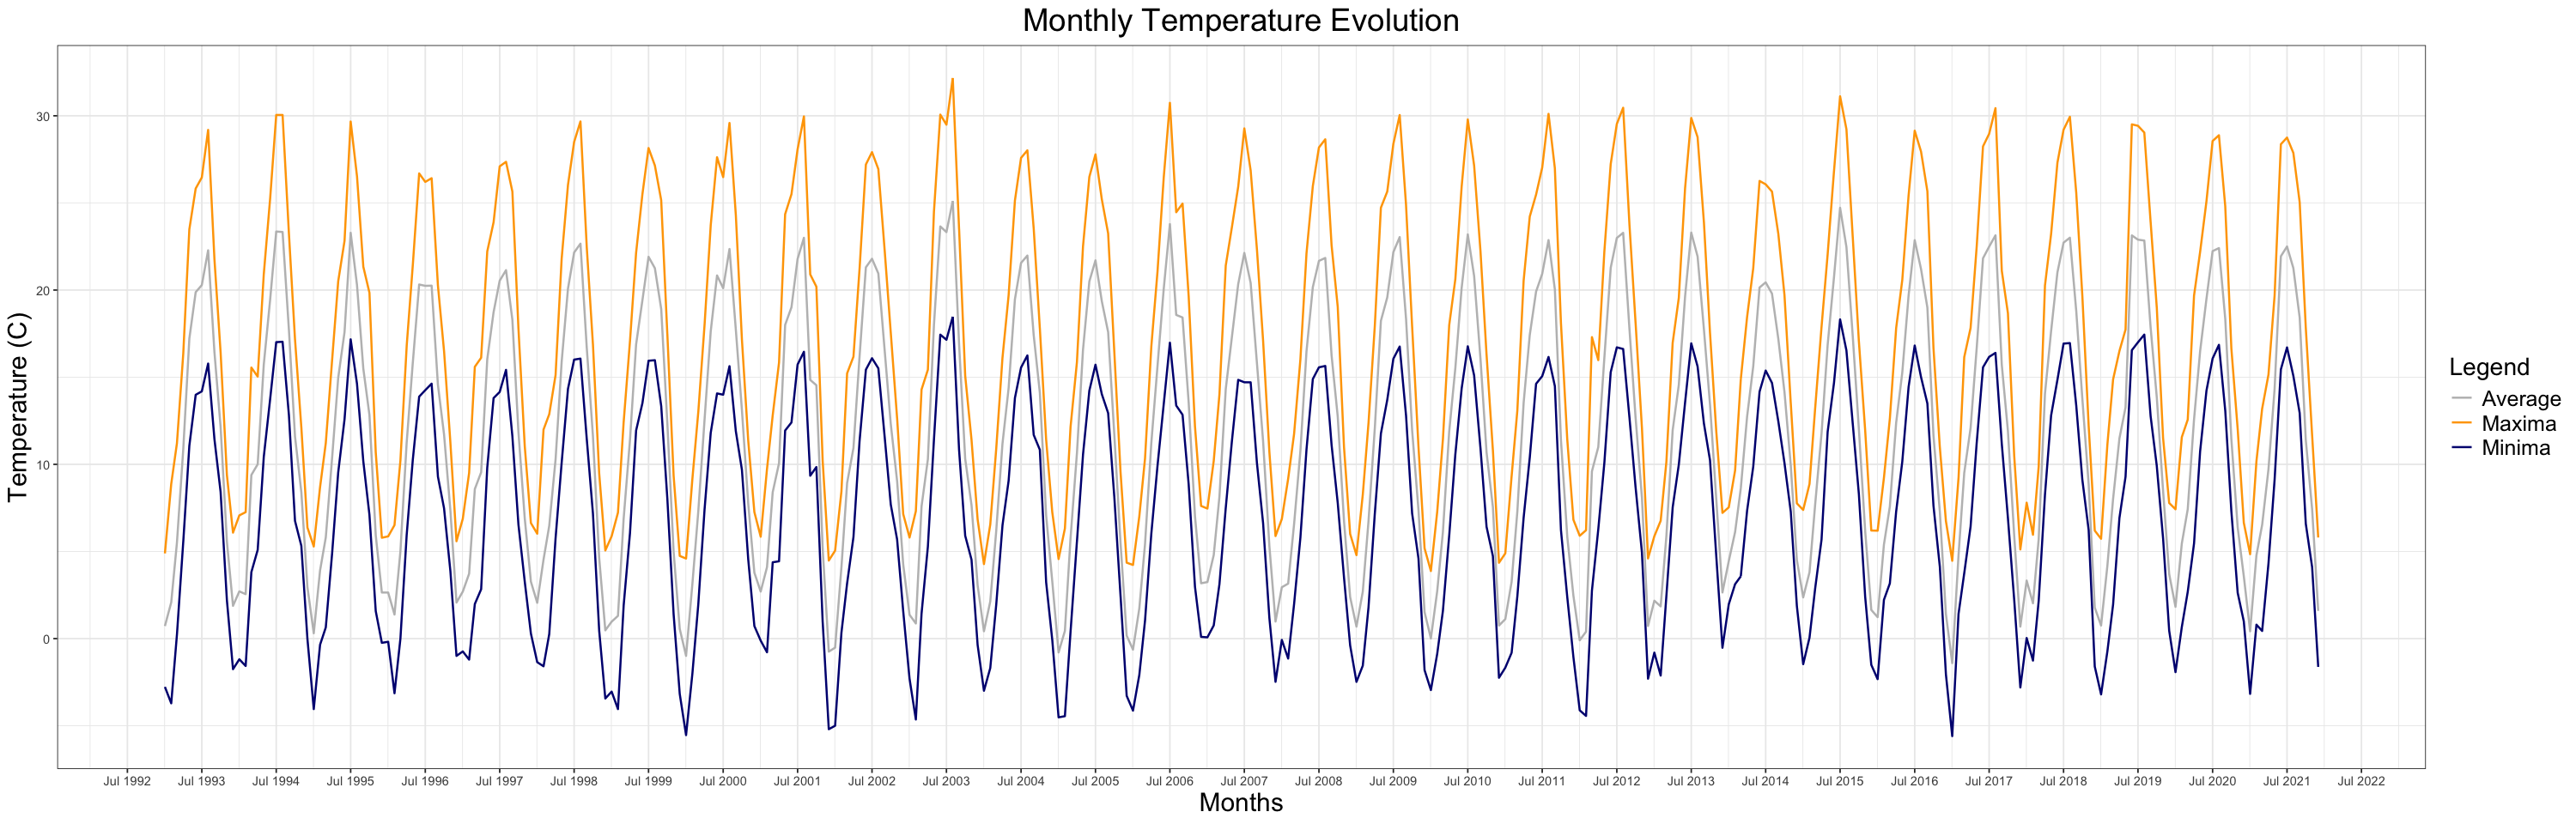

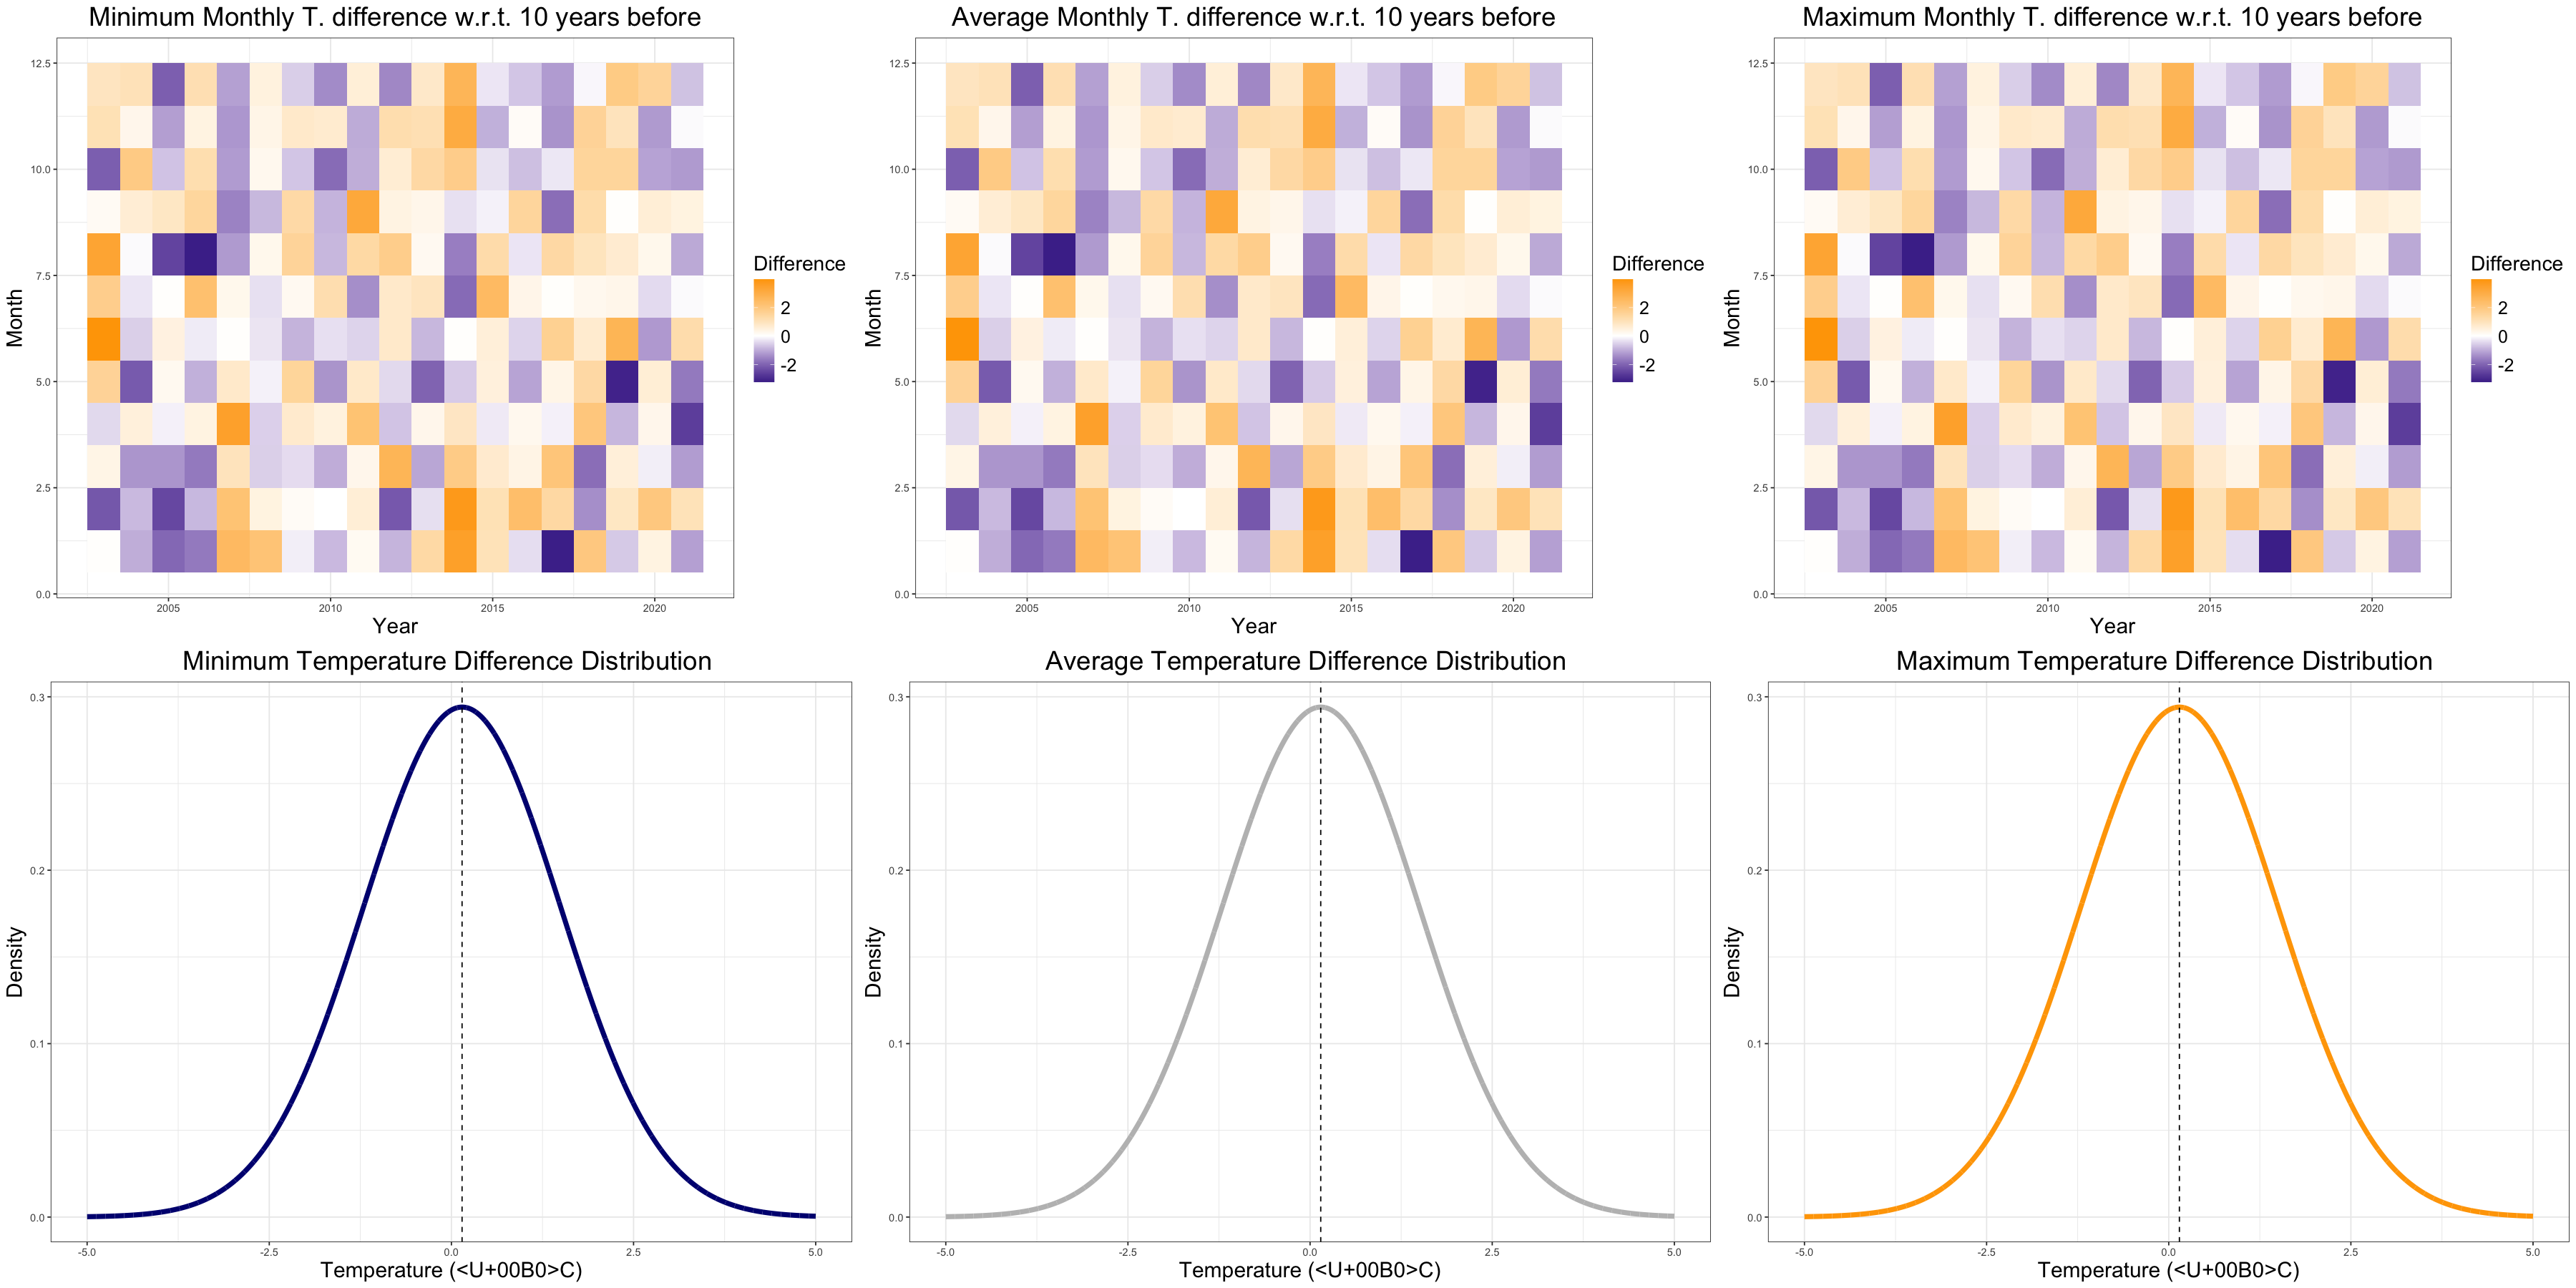

In [5]:
# Setting plot size
options(repr.plot.width = 25, repr.plot.height = 8)

# Monthly Plot
p_m <- ggplot(data = monthly_dataset) +
  geom_line(aes(x = month, y = MED_mean, color = 'Average'), group = 1, linewidth = 0.7) +
  geom_line(aes(x = month, y = MIN_mean, color = 'Minima'), group = 1, linewidth = 0.7) +
  geom_line(aes(x = month, y = MAX_mean, color = 'Maxima'), group = 1, linewidth = 0.7) +
  scale_color_manual(name = 'Legend', values = c('Minima' = 'navy', 'Maxima' = 'orange', 'Average' = 'gray')) +
  labs(title = 'Monthly Temperature Evolution',
       x = 'Months',
       y = 'Temperature (C)') +
  scale_x_date(date_breaks = "12 month", date_labels = "%b %Y") +
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

print(p_m)

par<-c('Minimum'='navy','Average'='gray','Maximum'='orange')
#Heatmap creation
h_min <- create_heatmap(df = monthly_dataset, str = par,index=1)
h_ava <- create_heatmap(df = monthly_dataset, str = par,index=2)
h_max <- create_heatmap(df = monthly_dataset, str = par,index=3)


#Normal plotting
plot_min <- norm_plot(h_min[[3]],h_min[[4]],type=par,index=1)
plot_ava <- norm_plot(h_ava[[3]],h_ava[[4]],type=par,index=2)
plot_max <- norm_plot(h_max[[3]],h_max[[4]],type=par,index=3)

options(repr.plot.width = 30, repr.plot.height = 15)
grid.arrange(h_min[[1]], h_ava[[1]], h_max[[1]], 
             plot_min, plot_ava, plot_max, 
             ncol = 3, nrow = 2)

It is clear that we cannot be sure at all that an increasing trend is present, as even if the mean is positive the variance is too big to tell.<br> Further statistical investigations are neede to assess the time series trend.

## **Annual Average Evolution Analysis**

We proceed the analysis with an annual average approach, namely averagin out the temperatures over each year and looking at the trend we find.

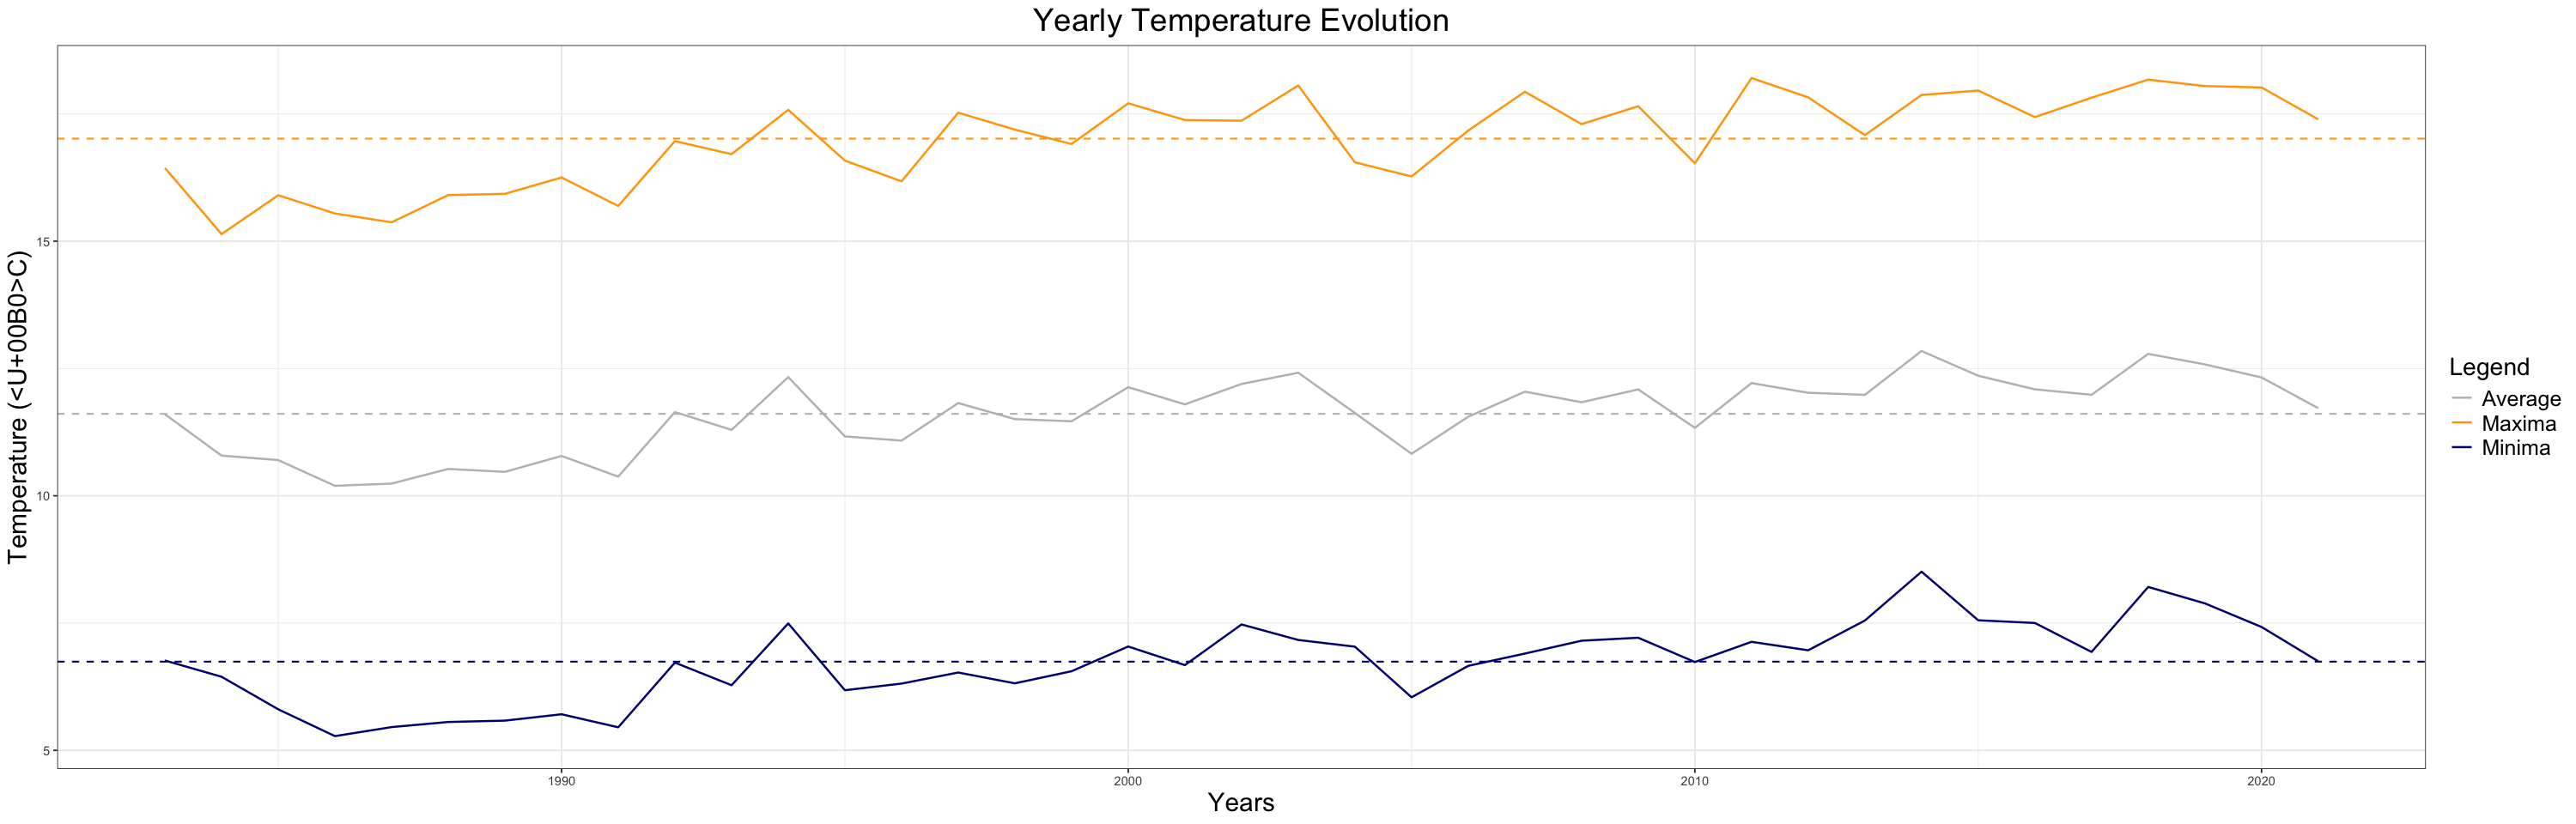

In [127]:
options(repr.plot.width = 25, repr.plot.height = 8)
# Annual Trend
p_y <- ggplot(data = yearly_dataset) +
  geom_line(aes(x = year_only, y = MED_mean, color = 'Average'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MED_mean)), color = 'gray', linewidth = 0.6, linetype = 2)+
  geom_line(aes(x = year_only, y = MIN_mean, color = 'Minima'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MIN_mean)), color = 'navy', linewidth = 0.6, linetype = 2)+
  geom_line(aes(x = year_only, y = MAX_mean, color = 'Maxima'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MAX_mean)), color = 'orange', linewidth = 0.6, linetype = 2)+  
  scale_color_manual(name = 'Legend', values = c('Minima' = 'navy', 'Maxima' = 'orange', 'Average' = 'gray')) +
  labs(title = 'Yearly Temperature Evolution',
       x = 'Years',
       y = 'Temperature (°C)') +
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

print(p_y)

A slight rising trend can be observed, particularly for the minima. We try to compare it with a constant and linear regression models by using the fitting tools provided in the *stats* package.

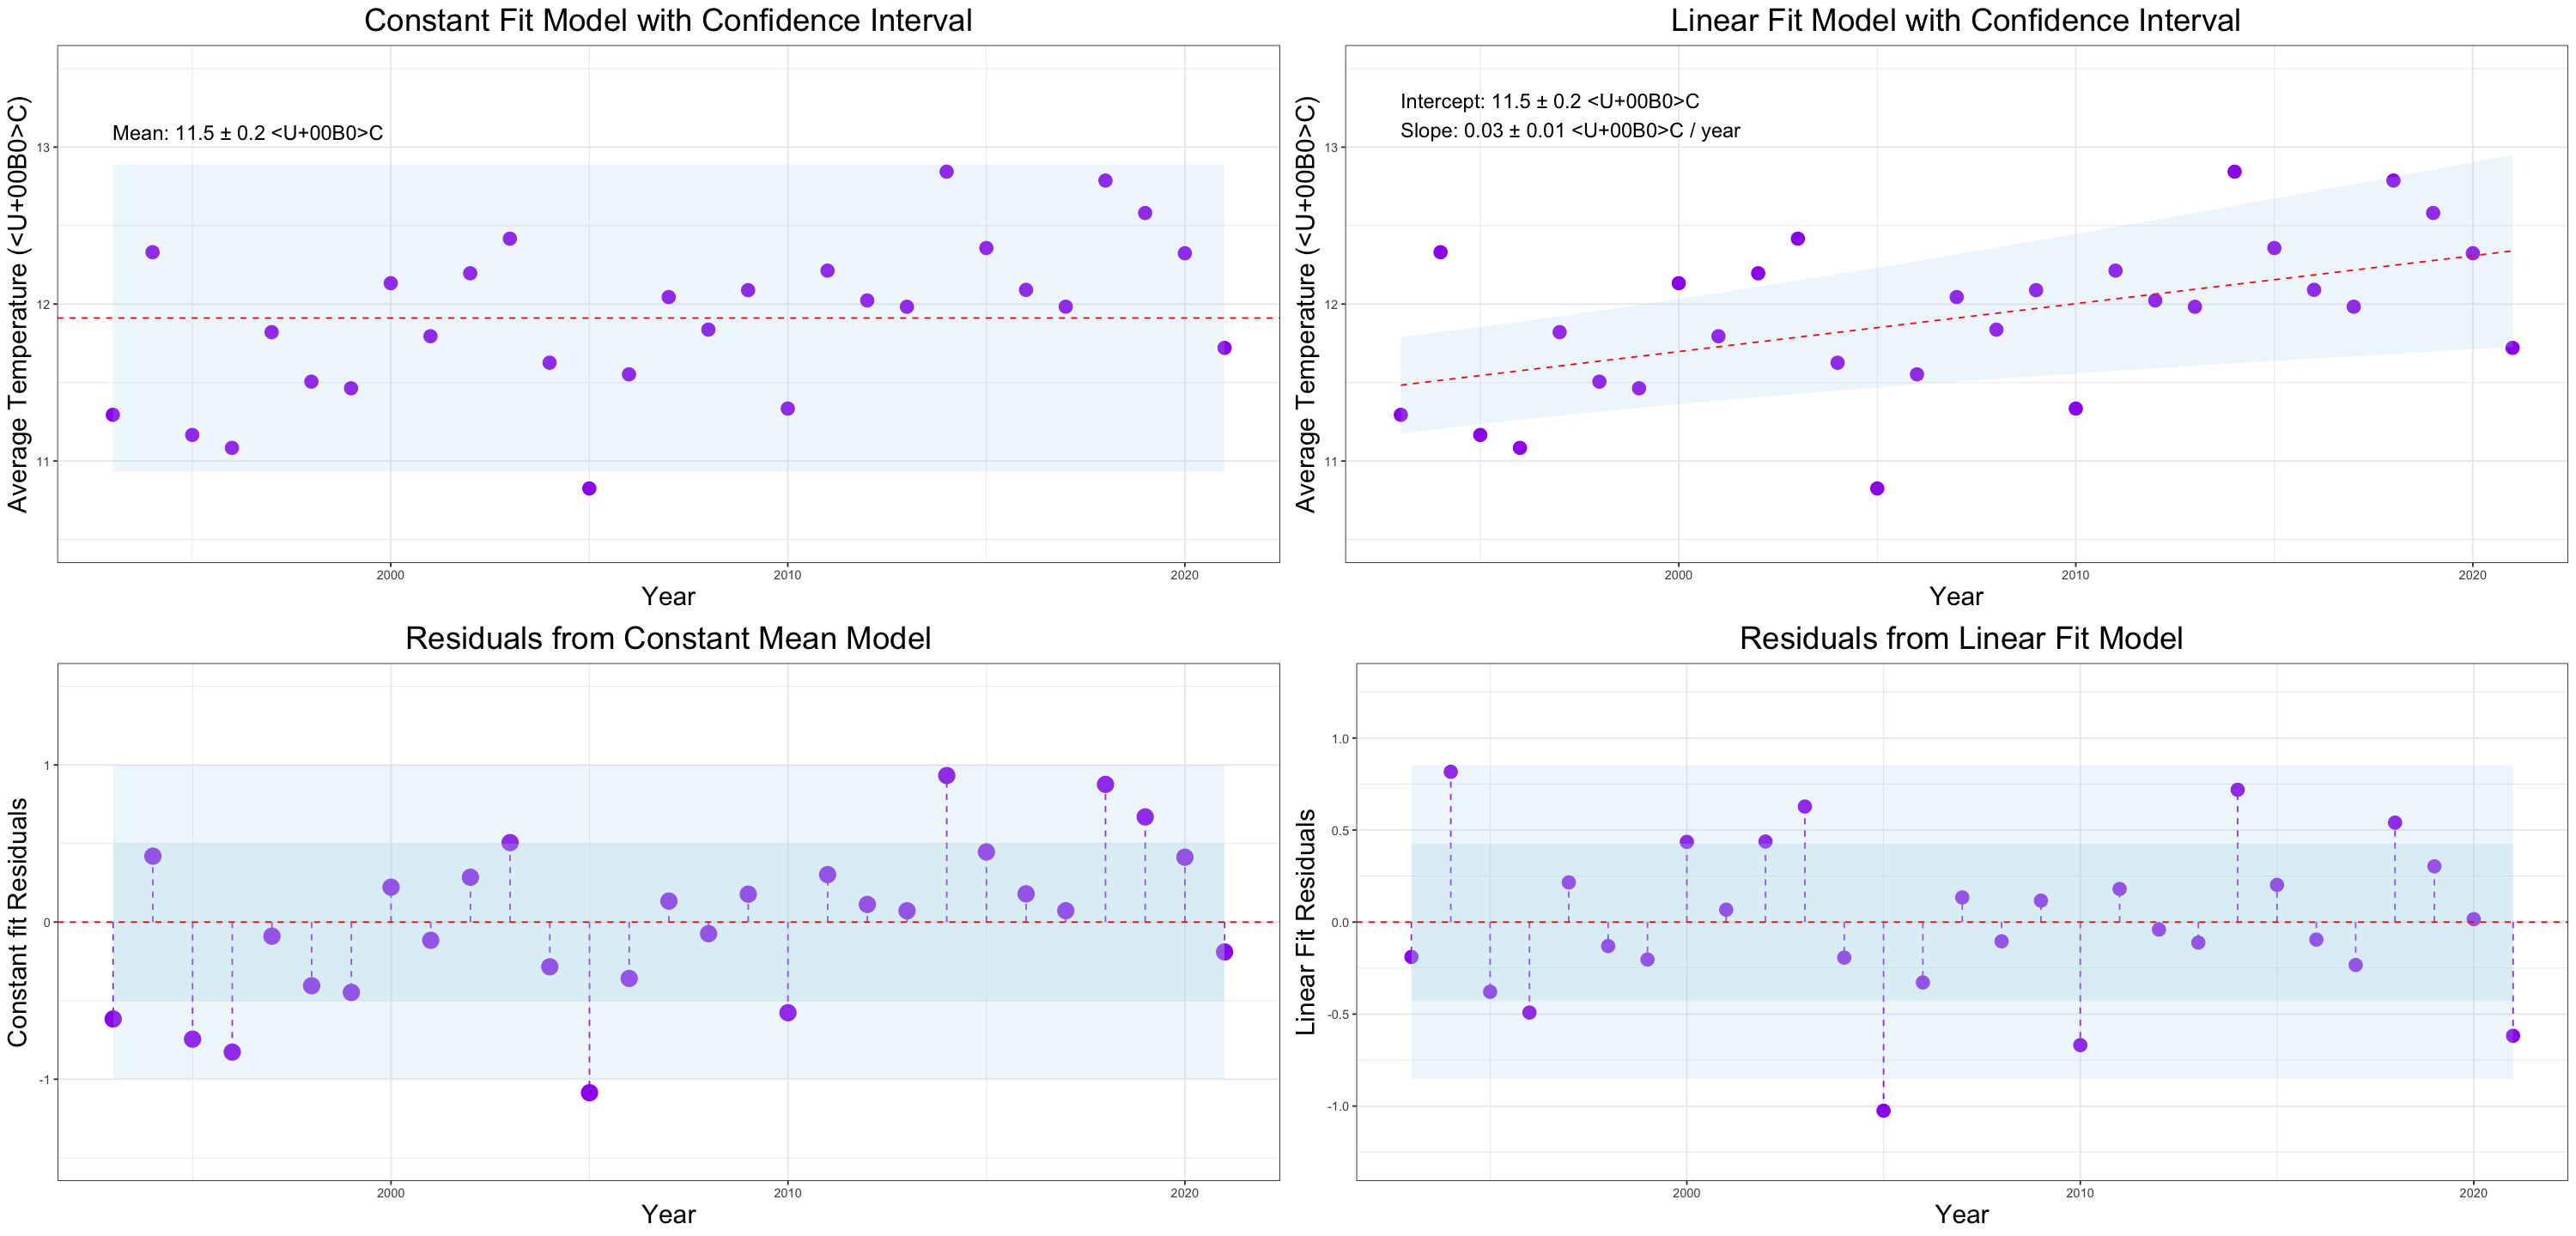

In [7]:
model <- lm(MED_mean ~ x_fit, data = yearly_dataset)
model_summary <- summary(model)
model_coeff_err <- coef(model_summary)[, "Std. Error"]
model_coeff <- coef(model_summary)[, 'Estimate']


fit_dataframe <- yearly_dataset |>
  select(year_only, MED_mean) |>
  mutate(linear_residuals = model$residuals) |>
  mutate(const_residuals = MED_mean - mean(MED_mean)) |>
  mutate(fitted_linear = model$fitted.values)

fit_dataframe <- fit_dataframe |>
  mutate(conf_lower = fitted_linear - 1.96 * sqrt((model_coeff_err[2] * yearly_dataset$x_fit)^2 + (model_coeff_err[1])^2),
         conf_upper = fitted_linear + 1.96 * sqrt((model_coeff_err[2] * yearly_dataset$x_fit)^2 + (model_coeff_err[1])^2)) |>
  mutate(x_fit = yearly_dataset$x_fit)


#constant_fit_text <- paste0("mean: ", round(mean(yearly_dataset$MED_mean), 1), 
                           # "\nsd: ", round(sqrt(var(yearly_dataset$MED_mean)), 1))
constant_fit_text <- paste0("Mean: ", round(model_coeff[1], 1), ' \u00B1 ', round(model_coeff_err[1], 1),' °C')

p_a <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = MED_mean), col = 'purple', size = 4) +
  geom_ribbon(aes(x = year_only, ymin = mean(MED_mean) - 1.96*sqrt(var(MED_mean)), 
                  ymax = mean(MED_mean) + 1.96*sqrt(var(MED_mean))), 
              alpha = 0.2, fill = 'lightblue') +
  geom_hline(aes(yintercept = mean(MED_mean)), linetype = 2, color = 'red') +
  theme_minimal() +
  ylim(10.5, 13.5) +
  annotate("text", x = min(fit_dataframe$year_only), y = max(fit_dataframe$MED_mean) + 0.3, 
           label = constant_fit_text, hjust = 0, vjust = 1, size = 5, color = 'black') +
  labs(title = "Constant Fit Model with Confidence Interval",
       x = "Year",
       y = "Average Temperature (°C)")+
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))


linear_fit_text <- paste0("Intercept: ", round(model_coeff[1], 1), ' \u00B1 ', round(model_coeff_err[1], 1),' °C', 
                          "\nSlope: ", round(model_coeff[2], 2), ' \u00B1 ', round(model_coeff_err[2], 2),' °C / year')

p_b <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = MED_mean), col = 'purple', size = 4) +
  geom_ribbon(aes(x = year_only, ymin = conf_lower, ymax = conf_upper), alpha = 0.2, fill = 'lightblue') +
  geom_line(aes(x = year_only, y = fitted_linear), linetype = 2, col = 'red') +
  theme_minimal() +
  ylim(10.5, 13.5) +
  annotate("text", x = min(fit_dataframe$year_only), y = max(fit_dataframe$MED_mean) + 0.5, 
           label = linear_fit_text, hjust = 0, vjust = 1, size = 5, color = "black") +
  labs(title = "Linear Fit Model with Confidence Interval",
       x = "Year",
       y = "Average Temperature (°C)")+
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

p_c <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = const_residuals), col = 'purple', size = 5) +
  geom_segment(aes(x = year_only, xend = year_only, y = 0, yend = const_residuals), linetype = 2, color = 'purple') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(MED_mean)), ymax = -sqrt(var(MED_mean))), alpha = 0.4, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(MED_mean)), ymax = 2*sqrt(var(MED_mean))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = 2*sqrt(var(MED_mean)), ymax = 3*sqrt(var(MED_mean))), alpha = 0., fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -2*sqrt(var(MED_mean)), ymax = -sqrt(var(MED_mean))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -3*sqrt(var(MED_mean)), ymax = -2*sqrt(var(MED_mean))), alpha = 0., fill = 'lightblue') +
  geom_hline(aes(yintercept = 0), linetype = 2, color = 'red') +
  theme_minimal() +
  labs(title = "Residuals from Constant Mean Model",
       x = "Year",
       y = "Constant fit Residuals")+
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))


p_d <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = linear_residuals), col = 'purple', size = 4) +
  geom_segment(aes(x = year_only, xend = year_only, y = 0, yend = linear_residuals), linetype = 2, color = 'purple') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(linear_residuals)), ymax = -sqrt(var(linear_residuals))), alpha = 0.4, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(linear_residuals)), ymax = 2 * sqrt(var(linear_residuals))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = 2 * sqrt(var(linear_residuals)), ymax = 3 * sqrt(var(linear_residuals))), alpha = 0.0, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -2 * sqrt(var(linear_residuals)), ymax = -sqrt(var(linear_residuals))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -3 * sqrt(var(linear_residuals)), ymax = -2 * sqrt(var(linear_residuals))), alpha = 0.0, fill = 'lightblue') +
  geom_hline(aes(yintercept = 0), linetype = 2, color = 'red') +
  theme_minimal() +
  labs(title = "Residuals from Linear Fit Model",
       x = "Year",
       y = "Linear Fit Residuals")+
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

options(repr.plot.width = 25, repr.plot.height = 12)


grid.arrange(p_a, p_b, p_c, p_d, 
             ncol = 2, nrow = 2)


From these initial fits, and particularly from their residuals, we can see that a linear trend appears to be more likely, as the residuals for the linear models appear to be more random, whereas we can see a slight rising trend in the ones from the constant model.<br>
The next step is to perform these fits once again this time simulating the parameters using a Monte Carlo Markov Chain with the *r-jags* package. 

In [81]:
init_variables <- function(model_name) {
    if (model_name == "lin_model") {
        return( list(a_min = runif(1, -20, 20), b_min = runif(1, -0.5, 0.5), sigma_min = runif(1, 0, 0.8),
                     a_max = runif(1, -20, 20), b_max = runif(1, -0.5, 0.5), sigma_max = runif(1, 0, 0.8),
                     a_ava = runif(1, -20, 20), b_ava = runif(1, -0.5, 0.5), sigma_ava = runif(1, 0, 0.8)))
    } else if (model_name == "const_model") {
        return( list(a_min = runif(1, -20, 20), sigma_min = runif(1, 0, 0.8),
                     a_max = runif(1, -20, 20), sigma_max = runif(1, 0, 0.8),
                     a_ava = runif(1, -20, 20), sigma_ava = runif(1, 0, 0.8)))
    }
}

regression <- function(df, model_file, params) {
    data <- df %>% select(x_fit, MAX_mean, MIN_mean, MED_mean)
    inits <- init_variables(gsub(".jags", "", model_file))
    jm <- jags.model(model_file, data, inits, n.chains = 1, n.adapt = 1000)
    update(jm, n.iter = 50000)
    chain <- coda.samples(jm, params, n.iter = 1e6, thin = 20)
    return(chain)
}

# modificato bene 
density_plot<- function(chain, type, temp){

    chain_df <- as.data.frame(as.mcmc(chain)) 
    quantiles <- summary(chain)$quantiles[,c('2.5%','97.5%')]

    a <- paste('a_', temp, sep='')
    b <- paste('b_', temp, sep='')
    sigma <- paste('sigma_', temp, sep='')
    
    lower_a <- quantiles[a, '2.5%']
    upper_a <- quantiles[a, '97.5%']
    plot_a <- ggplot(chain_df, aes_string(x = a)) +
        geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
        geom_vline(aes_string(xintercept = sprintf('mean(%s)', a)), linetype = 2) +
        geom_vline(aes(xintercept = lower_a), color = 'red') +
        geom_vline(aes(xintercept = upper_a), color = 'red') +
        labs(title = paste("Posterior Distribution of a"),
             x = 'a',
             y = "Density") +
        theme_bw() +
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))
 

    lower_sigma <- quantiles[sigma, '2.5%']
    upper_sigma <- quantiles[sigma, '97.5%']
    plot_sigma <- ggplot(chain_df, aes_string(x = sigma)) +
        geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
        geom_vline(aes(xintercept = lower_sigma), color = 'red') +
        geom_vline(aes(xintercept = upper_sigma), color = 'red') +
        geom_vline(aes_string(xintercept = sprintf('mean(%s)', sigma)), linetype = 2) +
        labs(title = paste("Posterior Distribution of sigma"),
             x = 'sigma',
             y = "Density") +
        theme_bw() +
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))


    if(type == 'linear'){

        lower_b <- quantiles[b, '2.5%']
        upper_b <- quantiles[b, '97.5%']
        plot_b <- ggplot(chain_df, aes_string(x = b)) +
            geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
            geom_vline(aes(xintercept = lower_b), color = 'red') +
            geom_vline(aes(xintercept = upper_b), color = 'red') +
            geom_vline(aes_string(xintercept = sprintf('mean(%s)', b)), linetype = 2) +
            labs(title = paste("Posterior Distribution of b"),
                 x = 'b',
                 y = "Density") +
            theme_bw() +
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

        return(grid.arrange(plot_a, plot_b, plot_sigma, ncol = 3, nrow = 1))
    } else {
        return(grid.arrange(plot_a, plot_sigma, ncol = 2, nrow = 1))
    }
}


trace_plot <- function(chain, type, temp) {

    chain_df <- as.data.frame(as.mcmc(chain)) 
    chain_df$iteration <- 1:length(chain_df[,1])

    a <- paste('a_', temp, sep='')
    b <- paste('b_', temp, sep='')
    sigma <- paste('sigma_', temp, sep='')
      
    if(type == 'linear'){
        
        plot_a <- ggplot(chain_df, aes_string(x = 1:nrow(chain_df), y = a)) +
            geom_line(alpha = 0.9, color = 'lightblue') +
            labs(title = paste("Trace Plot of a"),
                x = "Iteration",
                y = 'a') +
            theme_minimal()

        plot_sigma <- ggplot(chain_df, aes_string(x = 1:nrow(chain_df),  y = sigma)) +
            geom_line(alpha = 0.9, color = 'lightblue') +
            labs(title = paste("Trace Plot of sigma"),
                x = "Iteration",
                y = 'sigma') +
            theme_minimal()
        options(repr.plot.width = 25, repr.plot.height = 7)

        if(type == 'linear'){
            plot_b <- ggplot(chain_df, aes_string(x = 1:nrow(chain_df),  y = b)) +
                geom_line(alpha = 0.9, color = 'lightblue') +
                labs(title = paste("Trace Plot of b"),
                    x = "Iteration",
                    y = 'b') +
                theme_minimal()
            return(grid.arrange(plot_a, plot_b, plot_sigma, ncol = 3, nrow = 1))       
        }
        else {
            return(grid.arrange(plot_a, plot_sigma, ncol = 2, nrow = 1))
        }
    }
}


get_model_parameters <- function(chain, type, temp) {
    if(temp == 'min'){  
        chain_df <- as.data.frame( as.mcmc(chain) ) 
        if(type == 'linear'){
            parameters <- list(a = mean(chain_df$a_min), b = mean(chain_df$b_min), sigma = mean(chain_df$sigma_min),
                               sd_a = sd(chain_df$a_min), sd_b = sd(chain_df$b_min), sd_sigma= sd(chain_df$sigma_min) )
            return(parameters)
        }
        else if(type == 'constant'){
            parameters <- list(a = mean(chain_df$a_min), sigma = mean(chain_df$sigma_min),
                               sd_a = sd(chain_df$a_min),  sd_sigma= sd(chain_df$sigma_min) ) 
            return(parameters)
        }
    }
    else if(temp == 'max'){  
        chain_df <- as.data.frame( as.mcmc(chain) ) 
        if(type == 'linear'){
            parameters <- list(a = mean(chain_df$a_max), b = mean(chain_df$b_max), sigma = mean(chain_df$sigma_max),
                               sd_a = sd(chain_df$a_max), sd_b = sd(chain_df$b_max), sd_sigma= sd(chain_df$sigma_max) )
            return(parameters)
        }
        else if(type == 'constant'){
            parameters <- list(a = mean(chain_df$a_max), sigma = mean(chain_df$sigma_max),
                               sd_a = sd(chain_df$a_max),  sd_sigma= sd(chain_df$sigma_max) ) 
            return(parameters)
        }
    }
    else if(temp == 'ava'){  
        chain_df <- as.data.frame( as.mcmc(chain) ) 
        if(type == 'linear'){
            parameters <- list(a = mean(chain_df$a_ava), b = mean(chain_df$b_ava), sigma = mean(chain_df$sigma_ava),
                               sd_a = sd(chain_df$a_ava), sd_b = sd(chain_df$b_ava), sd_sigma= sd(chain_df$sigma_ava) )
            return(parameters)
        }
        else if(type == 'constant'){
            parameters <- list(a = mean(chain_df$a_ava), sigma = mean(chain_df$sigma_ava),
                               sd_a = sd(chain_df$a_ava),  sd_sigma= sd(chain_df$sigma_ava) ) 
            return(parameters)
        }
    }        
}

get_model_prediction <- function(chain, dataset, type, temp){

    if(type == 'linear'){
        parameters <- get_model_parameters(chain,type = 'linear', temp)
        y_pred <- parameters$a + (parameters$b * dataset$x_fit)        
    }
    else if(type == 'constant'){
        parameters <- get_model_parameters(chain,type = 'constant', temp)
        y_pred <- rep(parameters$a, length(dataset$x_fit))
    }
    return(y_pred)
}

get_model_likelihood <- function(chain, dataset, type, temp){
    param <- get_model_parameters(chain, type, temp)
    pred <- get_model_prediction(chain, dataset, type, temp)

    if(temp == 'min'){
        obs <- dataset$MIN_mean
    }
    else if(temp == 'max'){
        obs <- dataset$MAX_mean
    }
    else if(temp == 'ava'){
        obs <- dataset$MED_mean
    }
    return(-((log(param$sigma) * length(pred)) + sum(((obs - pred) / (sqrt(2) * param$sigma))^2)))
}


In [9]:
# Parametri per i modelli
lin_model_file <- "lin_model.jags"
lin_pars <- c("a_min", "b_min", "sigma_min", "a_max", "b_max", "sigma_max", "a_ava", "b_ava", "sigma_ava")

const_model_file <- "const_model.jags"
const_pars <- c("a_min", "sigma_min", "a_max", "sigma_max", "a_ava", "sigma_ava")

In [56]:
lin_chain <- regression(yearly_dataset, lin_model_file, lin_pars)
const_chain <- regression(yearly_dataset, const_model_file, const_pars)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 87
   Unobserved stochastic nodes: 9
   Total graph size: 312

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 87
   Unobserved stochastic nodes: 6
   Total graph size: 133

Initializing model



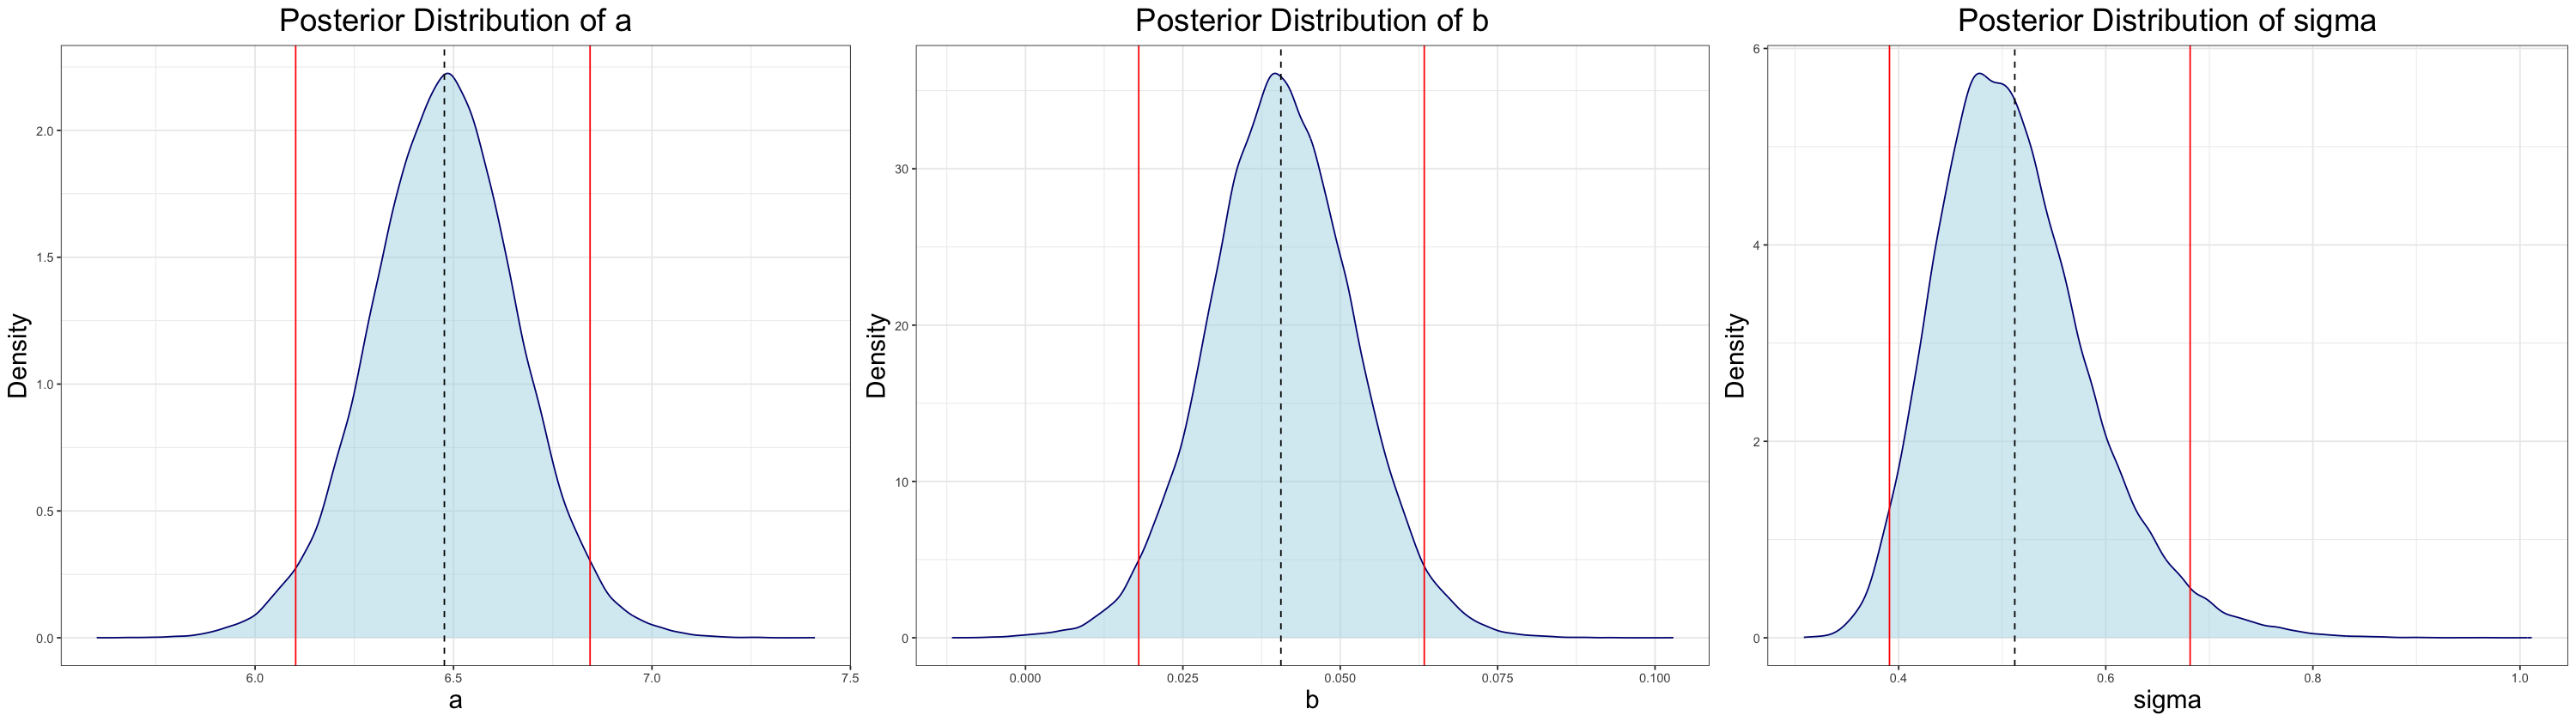

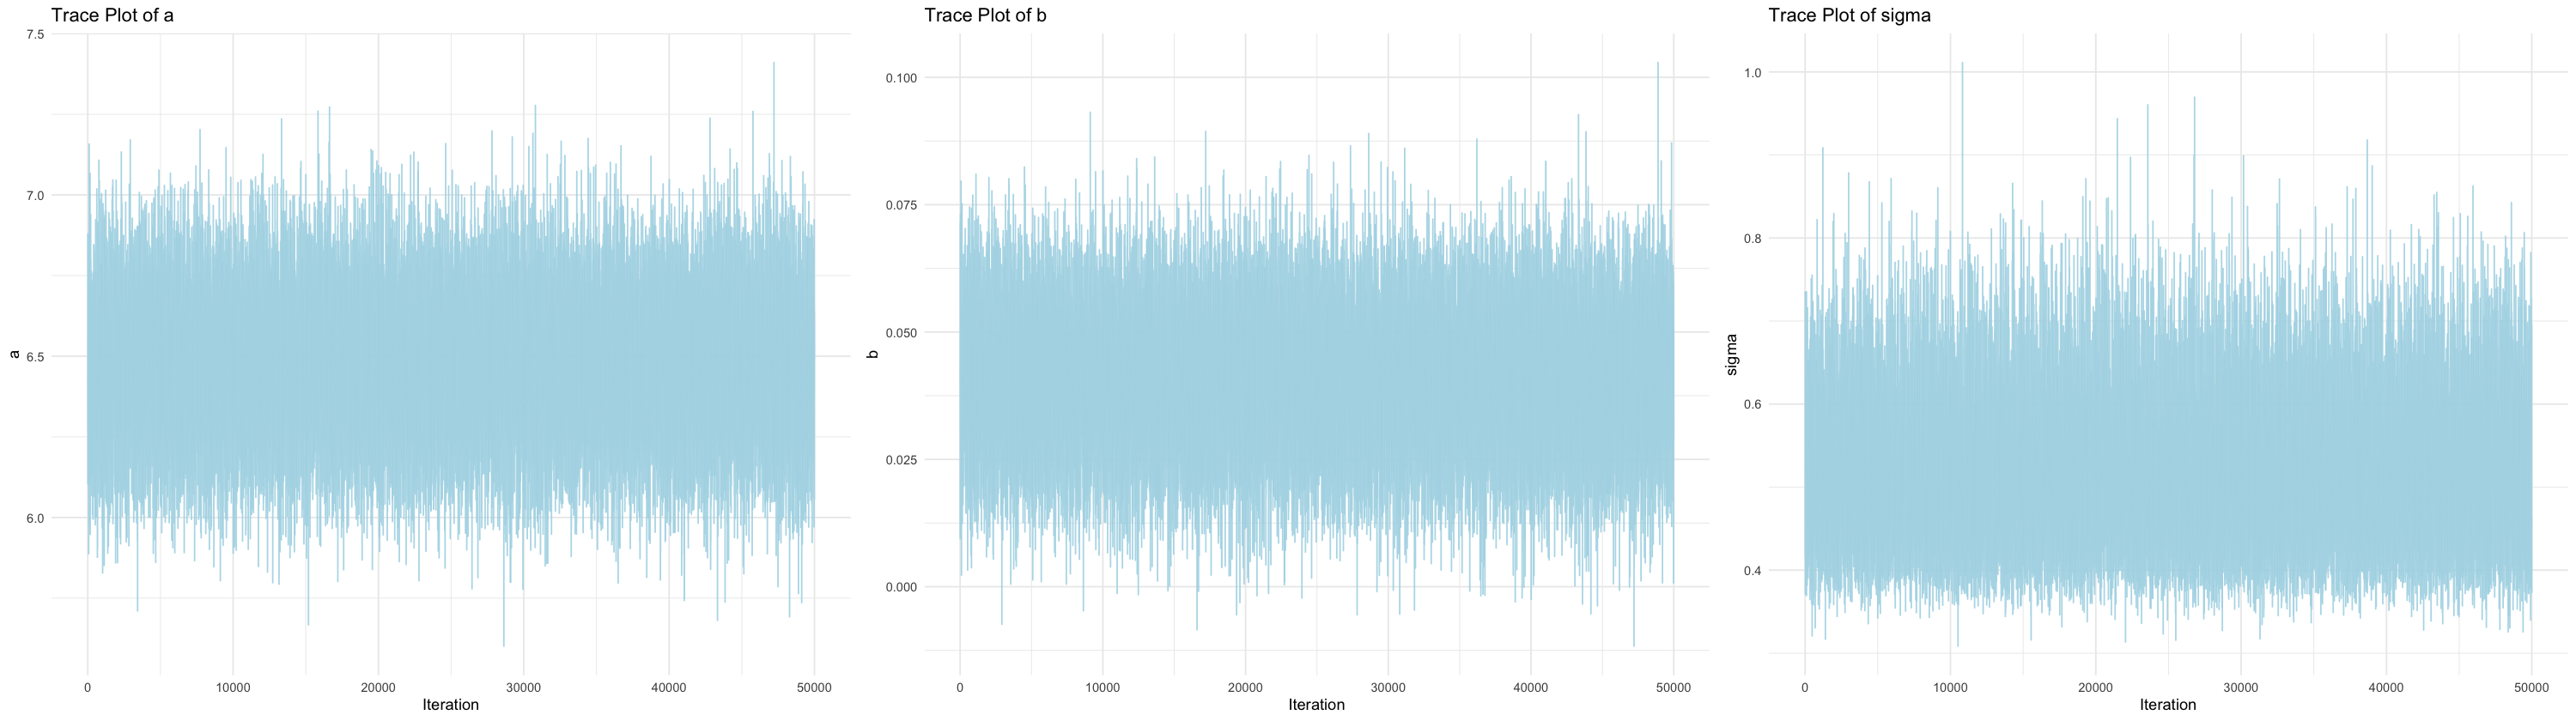

In [82]:
density_plot(lin_chain, 'linear', 'min')
trace_plot(lin_chain, 'linear', 'min')


log-likelihood linear model: 10.54 
log-likelihood constant model: 6.031662 
[1] 6.031662
Test value: 9.020907 
p-value: 0.00266909 


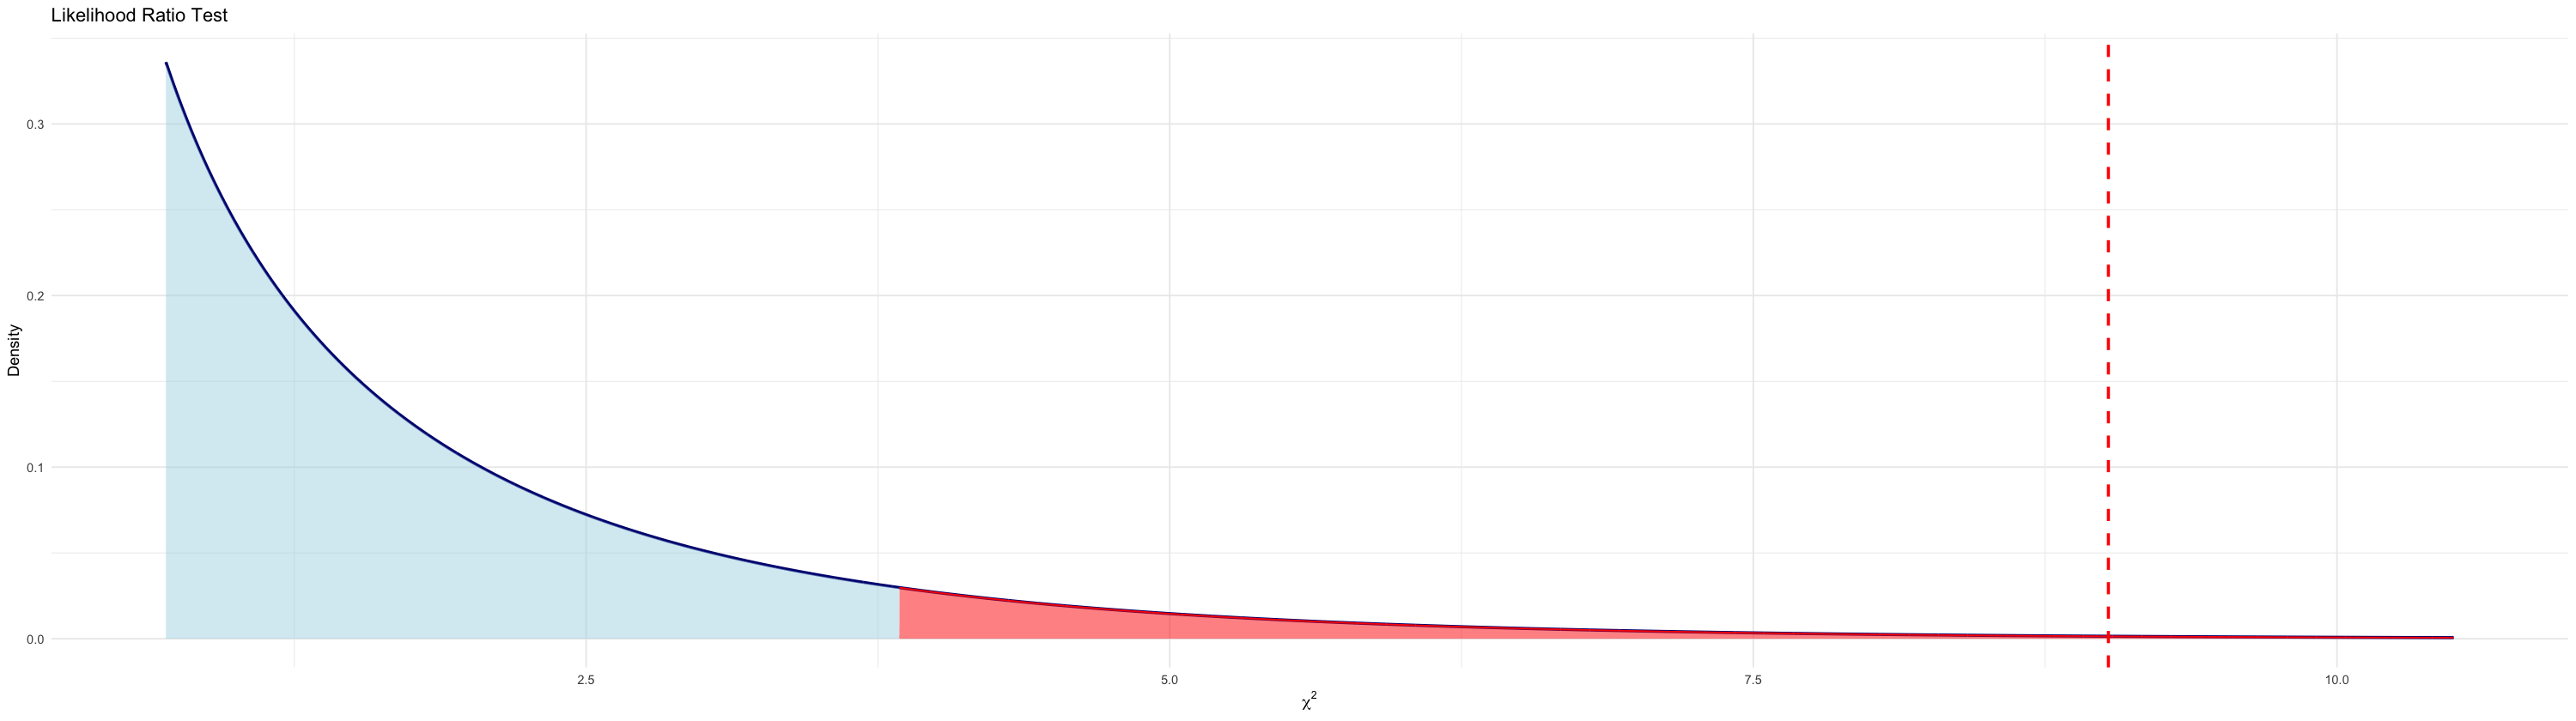

In [64]:
linear_likelihood <- get_model_likelihood(lin_chain, yearly_dataset, type = 'linear',temp = 'ava')
constant_likelihood <- get_model_likelihood(const_chain, yearly_dataset, type = 'constant', temp = 'ava')

log_likelihood_ratio <-   2 * ( linear_likelihood - constant_likelihood)
degree_freedom <- 1
p_value <- pchisq(log_likelihood_ratio, df = degree_freedom, lower.tail = FALSE)


cat('log-likelihood linear model:', round(linear_likelihood,2), '\n')
cat('log-likelihood constant model:', constant_likelihood, '\n')
print(constant_likelihood )
cat("Test value:", log_likelihood_ratio, "\n")
cat("p-value:", p_value, "\n")


x <- seq(0.7, 10.5, length.out = 10000)
y <- dchisq(x, degree_freedom)
chi_95 <- qchisq(0.95, df = degree_freedom)

data <- data.frame(x = x, y = y)

ggplot(data, aes(x = x, y = y)) +
  geom_line(color = "navy", size = 1) +
  geom_vline(xintercept = log_likelihood_ratio, color = "red", linetype = 2, size = 1) +
  geom_area(data = subset(data, x >= chi_95), aes(x = x, y = y), fill = "red", alpha = 0.5, color = 'red') +
  geom_area(data = subset(data, x <= chi_95), aes(x = x, y = y), fill = "lightblue", alpha = 0.5, color = 'navy') +
  labs(title = "Likelihood Ratio Test",
       x = expression(chi^2),
       y = "Density") +

  theme_minimal()

`summarise()` has grouped output by 'year_only'. You can override using the `.groups` argument.


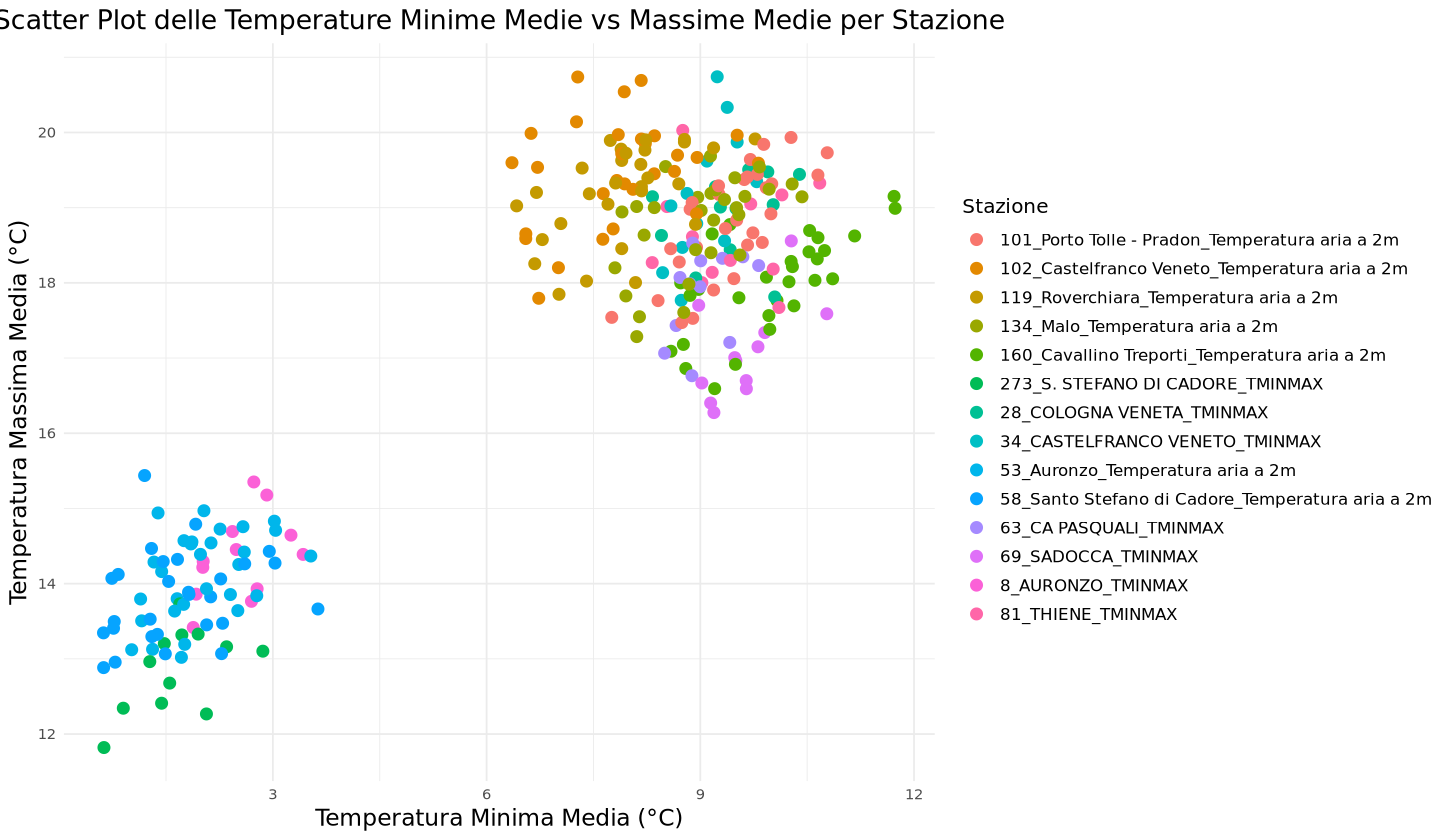

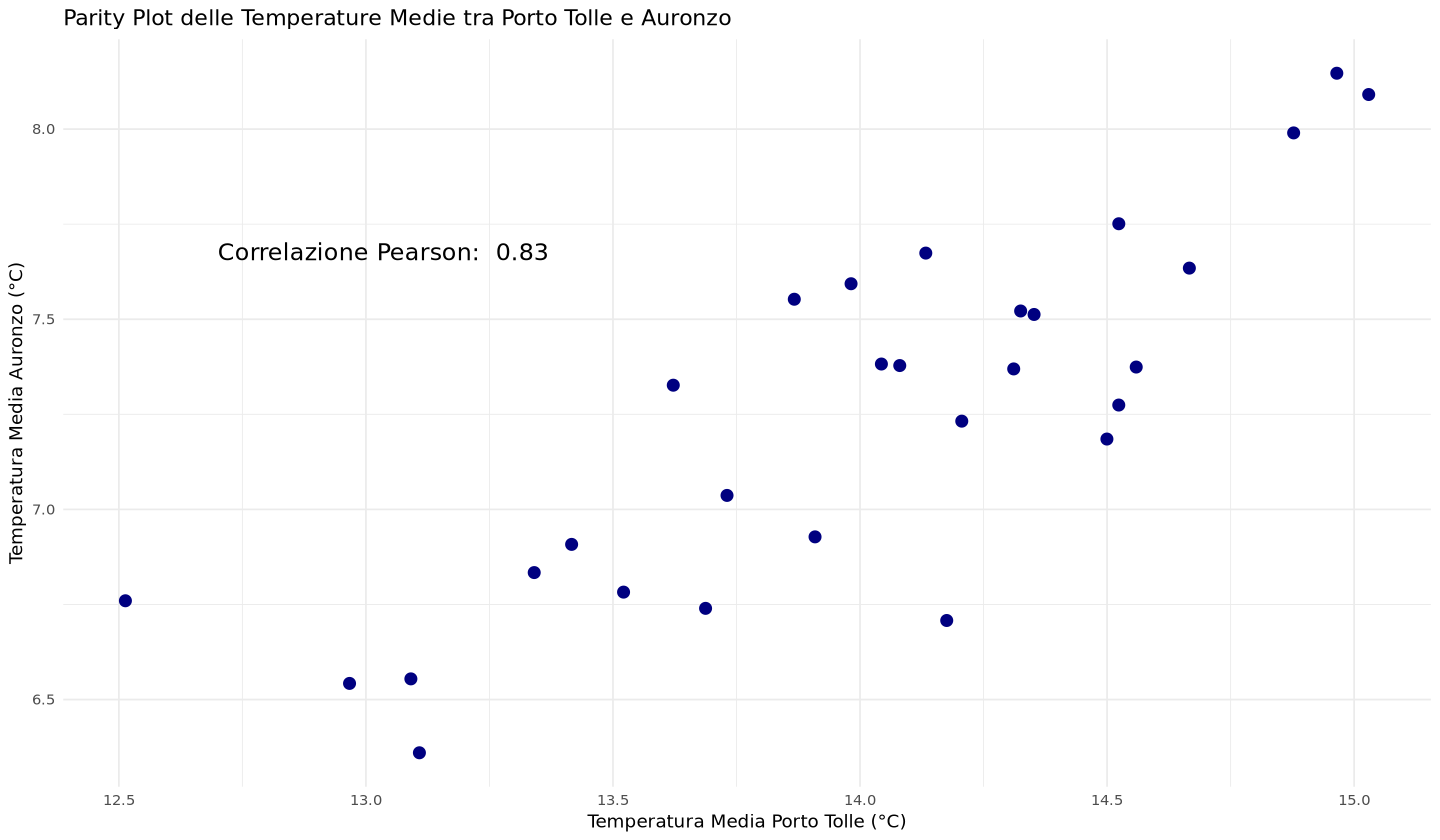

In [12]:

city_dataset <- daily_dataset |>
  group_by(year_only, file) |>
  summarise(MIN_mean = mean(TMIN, na.rm = TRUE),
            MED_mean = mean(TMED, na.rm = TRUE),
            MAX_mean = mean(TMAX, na.rm = TRUE))


porto_tolle <- city_dataset |> filter(file == '101_Porto Tolle - Pradon_Temperatura aria a 2m')
auronzo <- city_dataset |> filter(file == '53_Auronzo_Temperatura aria a 2m')
SantoStefano <- city_dataset |> filter(file == '273_S.Stefano_Temperatura aria a 2m')


corr_df1 <- data.frame(porto_tolle, auronzo)
corr_df2 <- data.frame(porto_tolle, auronzo)

# Opzioni per la dimensione del plot
options(repr.plot.width = 12, repr.plot.height = 7)


ggplot(city_dataset, aes(x = MIN_mean, y = MAX_mean, color = file)) +
  geom_point(size = 3) +
  labs(
    title = "Scatter Plot delle Temperature Minime Medie vs Massime Medie per Stazione",
    x = "Temperatura Minima Media (°C)",
    y = "Temperatura Massima Media (°C)",
    color = "Stazione"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 10)
  )


correlation_pearson <- cor(porto_tolle$MED_mean, auronzo$MED_mean, method = "pearson")
ggplot(corr_df, aes(x = MED_mean, y = MED_mean.1)) +
  geom_point(size = 3, color = 'navy') +
  labs(
    title = "Parity Plot delle Temperature Medie tra Porto Tolle e Auronzo",
    x = "Temperatura Media Porto Tolle (°C)",
    y = "Temperatura Media Auronzo (°C)"
  ) +
  theme_minimal() +
  annotate("text", x = 12.7 , y =7.7, 
           label = paste("Correlazione Pearson: ", round(correlation_pearson, 2)), 
           hjust = 0, vjust = 1, size = 5, color = "black") 

# Part 2

year_only,MIN_mean,MED_mean,MAX_mean,x_fit
<dbl>,<dbl>,<dbl>,<dbl>,<int>
1993,6.279188,11.29433,16.70935,1
1997,6.528919,11.82113,17.52378,2
2001,6.674016,11.79522,17.37981,3
2005,6.042278,10.82510,16.27128,4
2009,7.212099,12.08863,17.65046,5
2013,7.549836,11.98275,17.08315,6
2017,6.933232,11.98327,17.81874,7
2021,6.750020,11.72077,17.39425,8


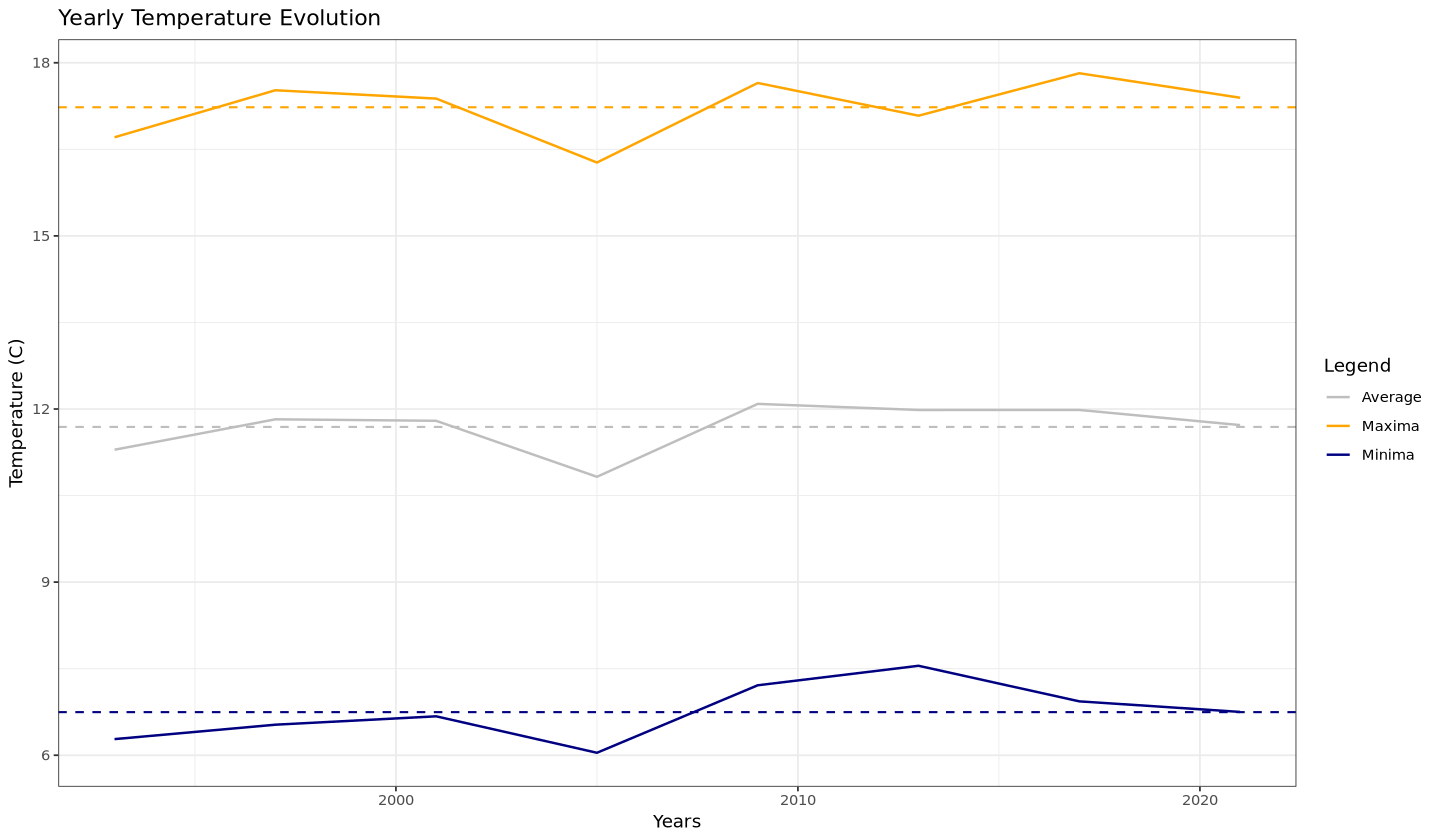

In [13]:
filtered <- yearly_dataset %>%
  filter((year_only - min(year_only))%% 4 == 0) |> mutate(x_fit = 1:length(year_only))

# Visualizziamo il dataframe filtrato
(filtered)

p_y <- ggplot(data = filtered) +
  geom_line(aes(x = year_only, y = MED_mean, color = 'Average'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MED_mean)), color = 'gray', linewidth = 0.6, linetype = 2)+
  geom_line(aes(x = year_only, y = MIN_mean, color = 'Minima'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MIN_mean)), color = 'navy', linewidth = 0.6, linetype = 2)+
  geom_line(aes(x = year_only, y = MAX_mean, color = 'Maxima'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MAX_mean)), color = 'orange', linewidth = 0.6, linetype = 2)+  
  scale_color_manual(name = 'Legend', values = c('Minima' = 'navy', 'Maxima' = 'orange', 'Average' = 'gray')) +
  labs(title = 'Yearly Temperature Evolution',
       x = 'Years',
       y = 'Temperature (C)') +
  theme_bw()
p_y


In [14]:
lin_chain <- regression(filtered, lin_model_file, lin_pars)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 24
   Unobserved stochastic nodes: 9
   Total graph size: 102

Initializing model



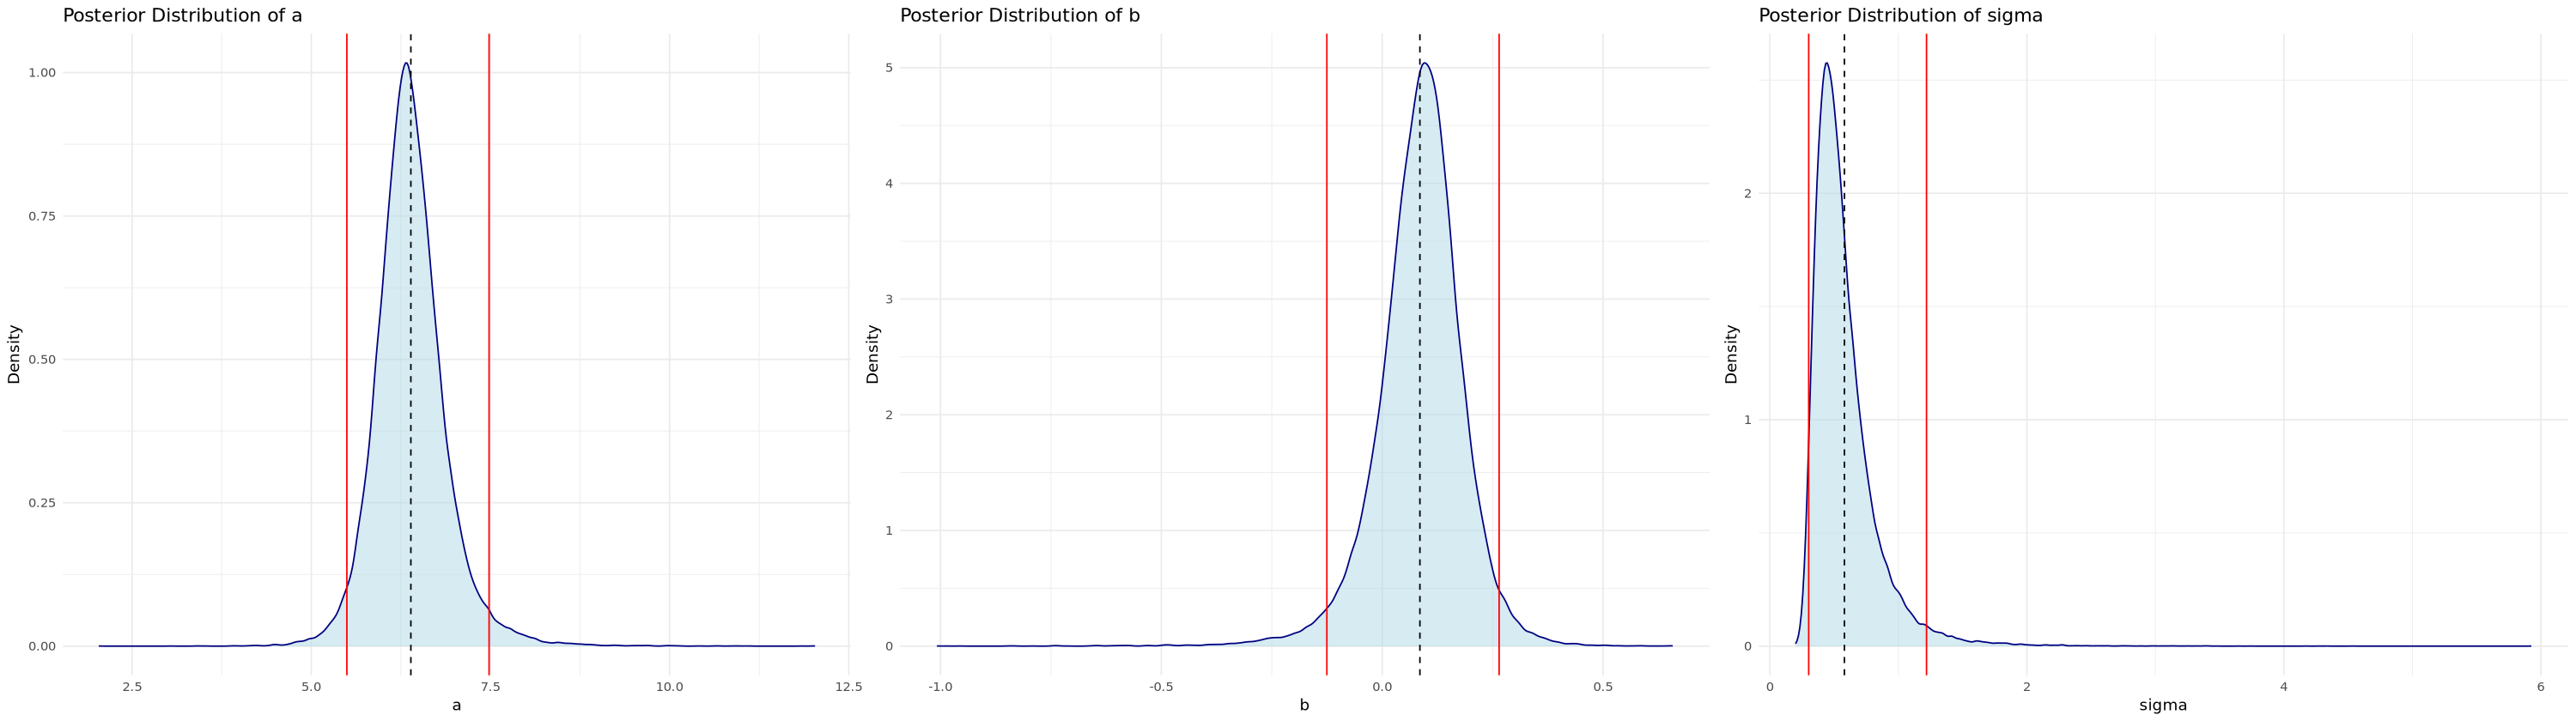

In [15]:
density_plot(lin_chain, 'linear', 'min')

### comparing snpa and our regression
http://www.math.nagoya-u.ac.jp/~richard/teaching/s2021/SML_Guozhang6.pdf



We want now to compare the values we infer from the montecarlo process with the one obtained in snpa document so our hypotesis test is set as:


$\left\{\begin{array}{rl}
H_0 : b' \in [\mu_{snpa} - k, \mu_{snpa} + k]\\
H_0 : b' \not\in [\mu_{snpa} - k, \mu_{snpa} + k]
\end{array}
\right.$

with $k$ half of the confidential interval. If now we rescale the distribution of b we can obtain $b' \sim N(\mu', \sigma') : \mu' = \frac{10}{4}\mu_b , \sigma' = \frac{10}{4}\sigma_b$ so now 

$P(H_0 | \mu_{snpa}, k, b') = P(b' \in [\mu_{snpa} - k, \mu_{snpa} + k]) = \int_{\mu_{snpa} - k}^{\mu_{snpa} + k} p(b') db'$

p value : 0.15
We can't refuse H_0

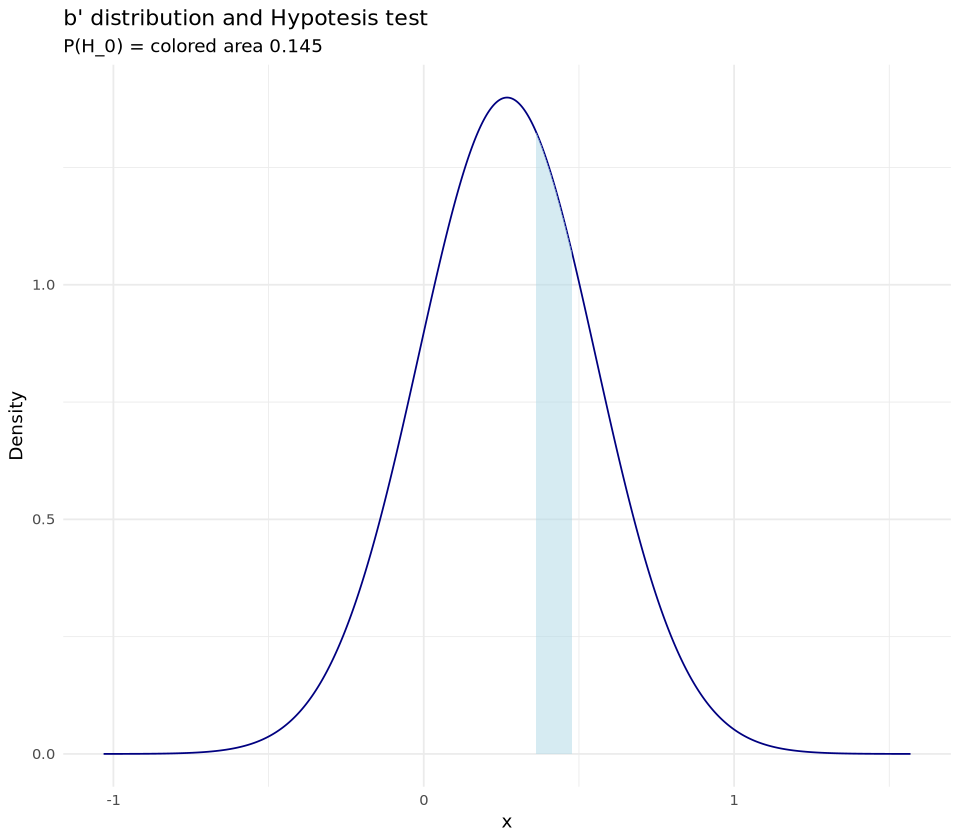

p value : 0.11
We can't refuse H_0

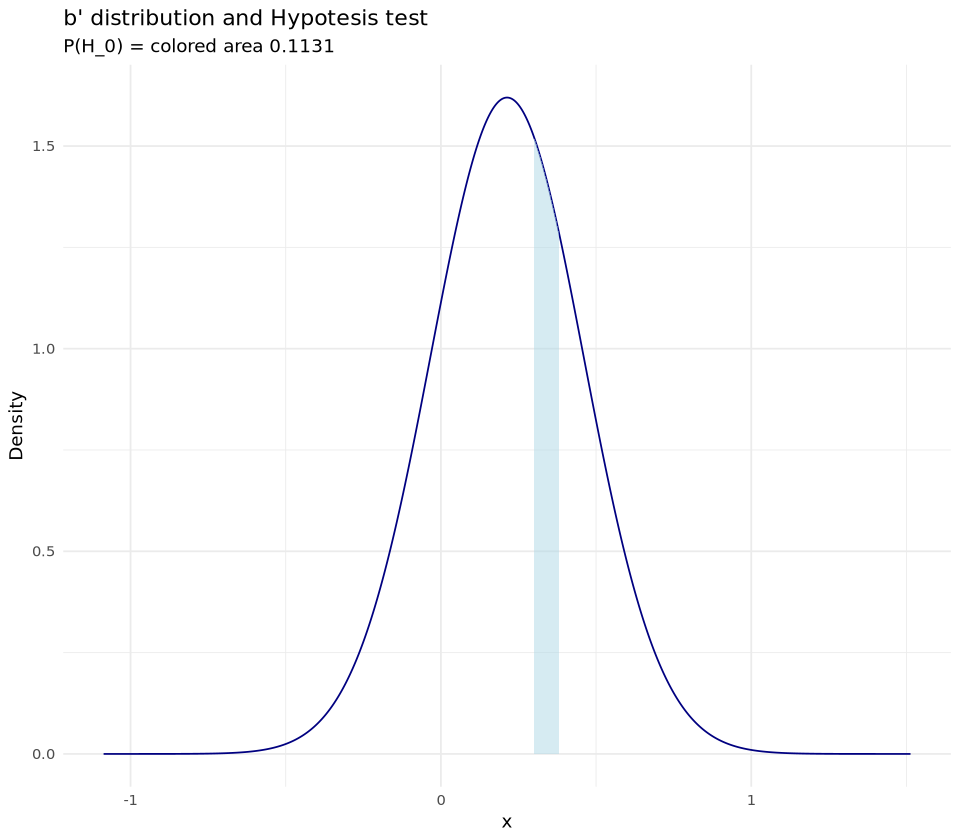

p value : 0.11
We can't refuse H_0

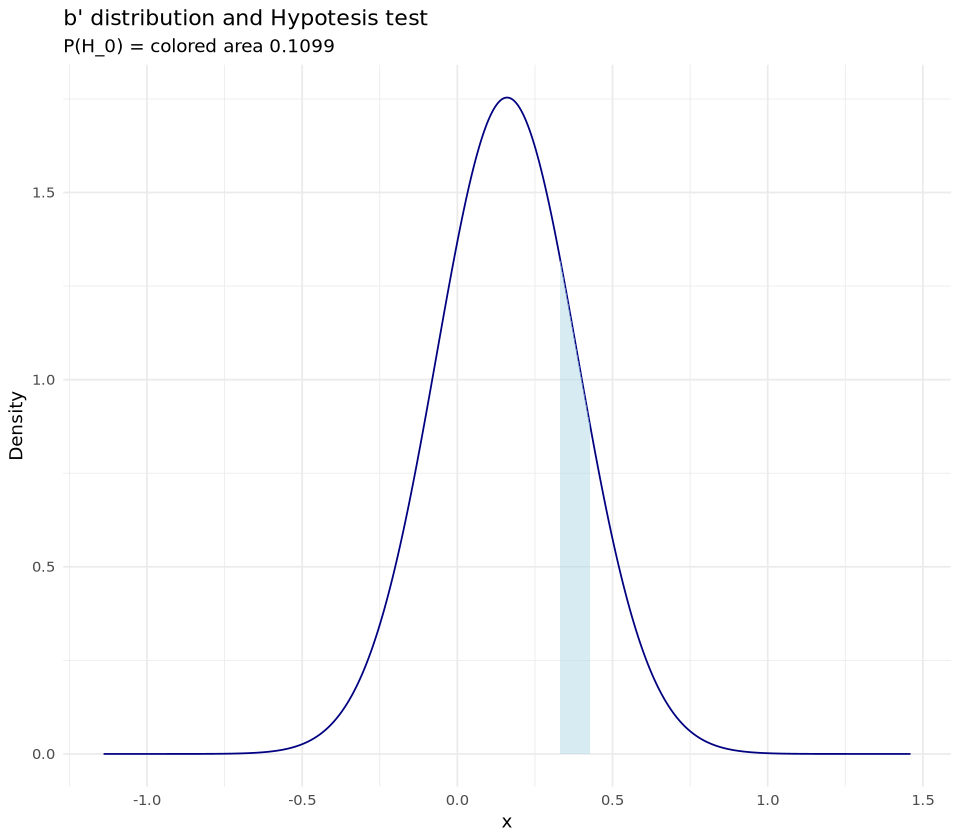

In [16]:
snpa_htest <- function(chain, temp){

    if(temp == 'max'){
        snpa <- list( mu = 0.42, k = 0.06 )
    }
    if(temp == 'ava'){
        snpa <- list( mu = 0.38, k = 0.05 )
    }
    if(temp == 'min'){
        snpa <- list( mu = 0.34, k = 0.04 )
    }

    b_prime_param <- get_model_parameters(chain ,type = 'linear',temp)
    b_prime_mu <- 2.5*b_prime_param[['b']]
    b_prime_sd <- 2.5*b_prime_param[['sd_b']]

    x = seq(b_prime_mu-1.3,b_prime_mu+1.3,0.002)
    b_prime_post <- dnorm(x, b_prime_mu, b_prime_sd)
    test_area <- integrate(dnorm, lower = snpa[['mu']]-snpa[['k']], upper = snpa[['mu']]+snpa[['k']], mean = b_prime_mu, sd = b_prime_sd)$value


    df <- data.frame(x = x, y = b_prime_post)
    options(repr.plot.width = 8, repr.plot.height = 7)
    plot <- ggplot(df, aes(x = x, y = y)) +
        geom_line(color = 'navy') +
        geom_area(data = subset(df, x >= snpa[['mu']]-snpa[['k']] & x <= snpa[['mu']]+snpa[['k']]), aes(x = x, y = y), fill = 'lightblue', alpha = 0.5) +
        labs(title = "b' distribution and Hypotesis test",
             subtitle = paste("P(H_0) = colored area", round(test_area, 4)),
             x = "x",
             y = "Density") +
        theme_minimal()
    print(plot)
        
    chaindf <- as.data.frame( as.mcmc(chain))[['b_min']]
    filtered_b_ava <- chaindf[2*chaindf >= (snpa[['mu']] - snpa[['k']])]
    filtered_b_ava <- filtered_b_ava[2*filtered_b_ava <= (snpa[['mu']] + snpa[['k']])]

        cat('p value :', round(test_area,2))
    if(test_area > 0.05){
        cat('\nWe can\'t refuse H_0')
    }
    else if(test_area <= 0.05){
        cat('\nWe refuse H_0')
    }
}


snpa_htest(lin_chain, temp = 'max')
snpa_htest(lin_chain, temp = 'min')
snpa_htest(lin_chain, temp = 'ava')

In [220]:

ts_data <- diff(yearly_dataset$MIN_mean)
#ts_data <- yearly_dataset$MIN_mean


In [257]:
find_best_arima_model <- function(timeseries, iterations) {
    # Divide the series into training and test sets
    
    n_train <- floor(0.75 * length(timeseries))
    training_set <- timeseries[1:n_train] 
    test_set <- timeseries[(n_train + 1):length(timeseries)]  

    # Initialize variables to store the best model
    best_model <- NULL
    best_rmse <- Inf 
    best_aic <- Inf  
    best_params <- NULL
    
    set.seed(123)
    
    # Iterate to find the best ARIMA model
    for (i in 1:iterations) {
        p <- sample(0:4, 1)
        d <- sample(0:4, 1)
        q <- sample(0:4, 1)
        
        model <- Arima(training_set, order = c(p, d, q),include.mean = TRUE)
        forecasts <- forecast(model, h = length(test_set))
        
        # Calculate RMSE
        #rmse <- sqrt(mean((forecasts$mean - test_set)^2))
        aic <- AIC(model)

        # Update best model if current model is better
        if (aic < best_aic){
            best_model <- model
            #best_rmse <- rmse
            best_aic <- aic
            best_params <- c(p, d, q)
        }
    }
    
    # Train the best model on the entire dataset
    final_model <- Arima(timeseries, order = best_params)
    
    return(list(best_model = final_model, training = training_set, test = test_set, best_params = best_params))
}



In [258]:
model <- find_best_arima_model(ts_data,iterations = 100)$best_model
summary(model)


Series: timeseries 
ARIMA(0,0,1) with non-zero mean 

Coefficients:
          ma1    mean
      -1.0000  0.0416
s.e.   0.1024  0.0106

sigma^2 = 0.2471:  log likelihood = -20.8
AIC=47.61   AICc=48.61   BIC=51.6

Training set error measures:
                       ME      RMSE       MAE      MPE     MAPE      MASE
Training set -0.008053957 0.4789794 0.3696157 23.38268 83.94075 0.4587716
                  ACF1
Training set 0.0876751

Series: timeseries 
ARIMA(0,0,1) with non-zero mean 

Coefficients:
          ma1    mean
      -1.0000  0.0416
s.e.   0.1024  0.0106

sigma^2 = 0.2471:  log likelihood = -20.8
AIC=47.61   AICc=48.61   BIC=51.6

Training set error measures:
                       ME      RMSE       MAE      MPE     MAPE      MASE
Training set -0.008053957 0.4789794 0.3696157 23.38268 83.94075 0.4587716
                  ACF1
Training set 0.0876751

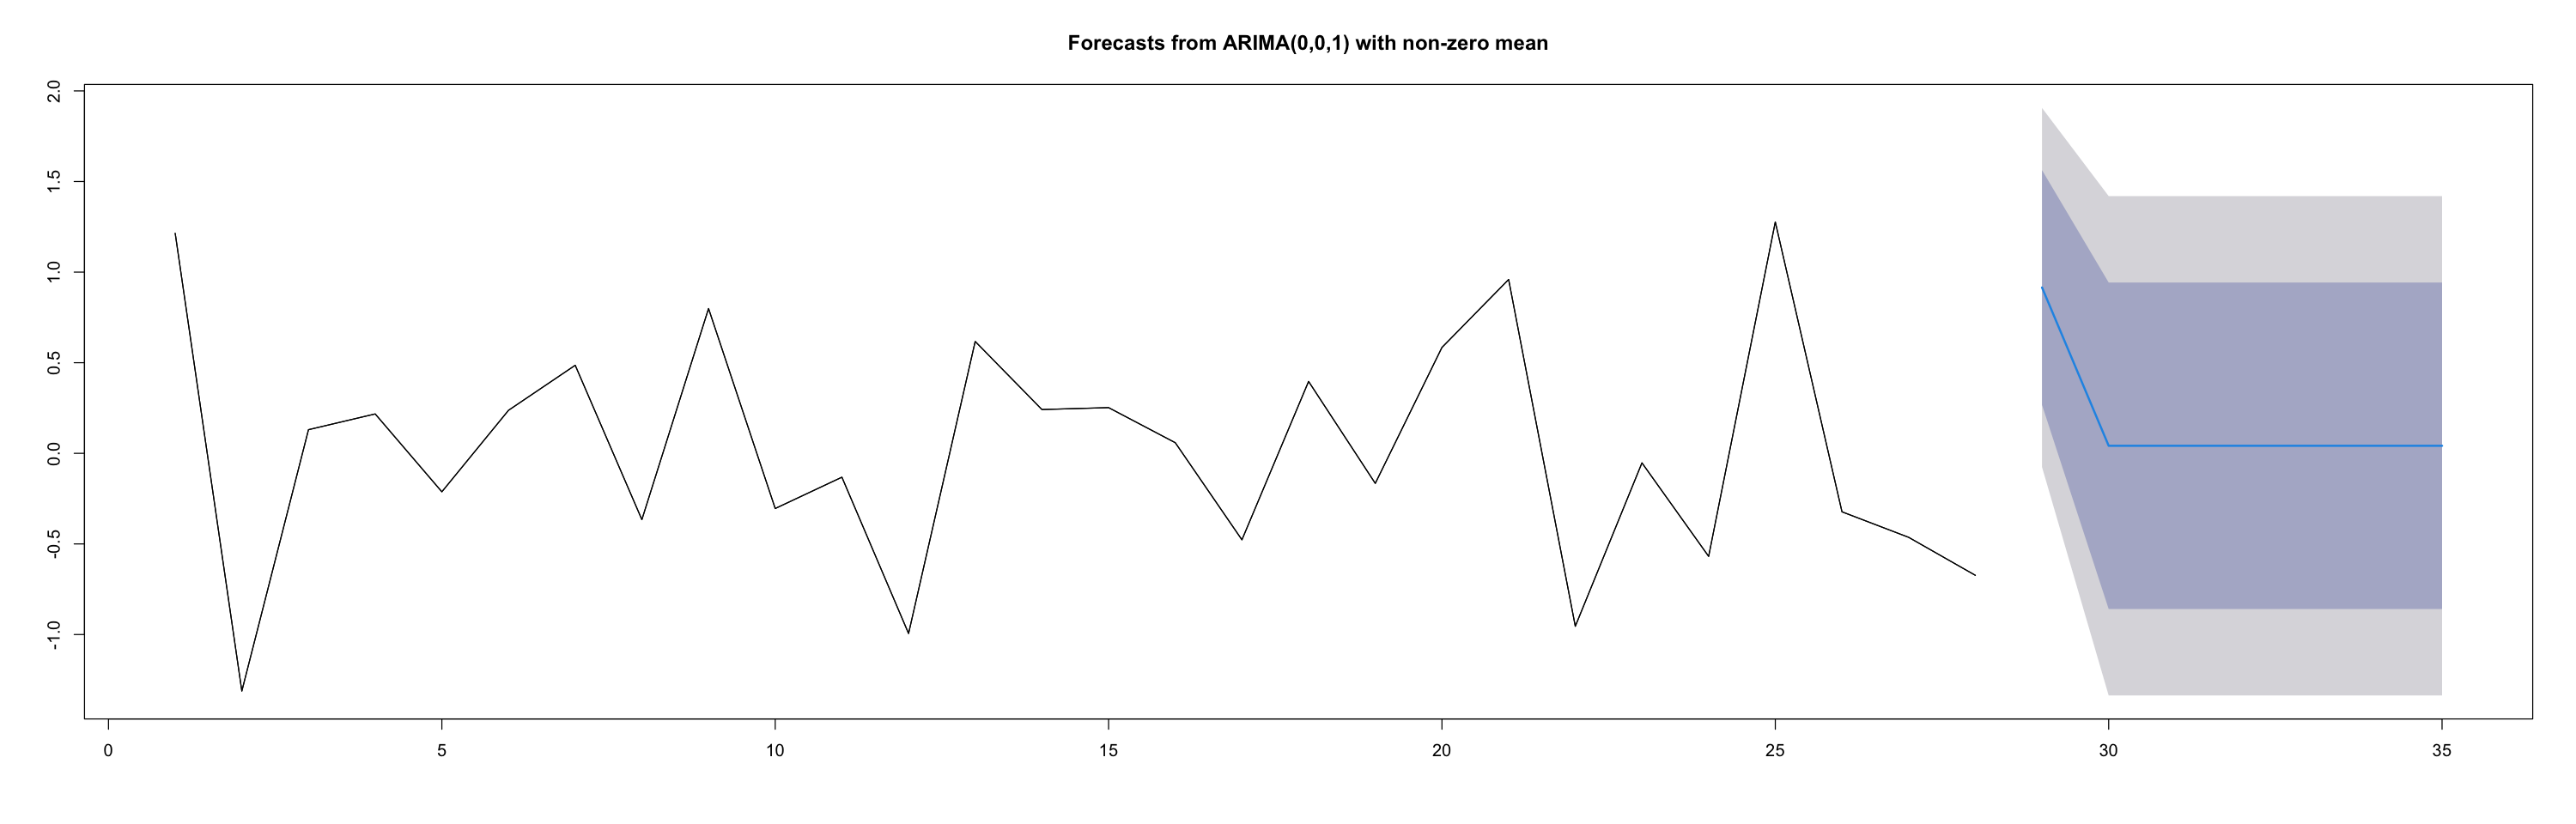

In [259]:
forecast <- forecast(object = model,h = 7)
plot(forecast)
lines(ts_data)
summary(model)